In [2]:
#####################################################################
#### Using Netatmo to validate the global daily air temp dataset ####
#####################################################################

#import the required packages
import pandas as pd
import os
import earthpy as et
import pathlib
import numpy as np
import matplotlib as mpl
import geopandas as gpd
import pickle
import datetime
# for plotting
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [3]:
#load up the netatmo data
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'DDL', 'Netatmo','Data','AirTempEVal'))
AT_Day_all_df = pd.read_csv('AT_Day_all.csv')
AT_Night_all_df = pd.read_csv('AT_Night_all.csv')
netatmo_clusterID_ref_df = pd.read_csv('netatmo_clusterID_ref.csv')
netatmo_ID_cleaned_df = pd.read_csv('netatmo_ID_cleaned.csv')
netatmo_temp_humid_cleaned_df = pd.read_csv('netatmo_temp_humid_cleaned.csv')

In [4]:
# load in the climate classifications for the USEI cities
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'DDL', 'Netatmo','Data'))
clim_zone_codes = pd.read_csv('clim_zone_codes.csv')
climate_zone = pd.read_csv('climate_zone.csv')
# add in the main climate zone, classification which has the max number of pixels
# 0 code means over the ocean, drop this
climate_zone = climate_zone.drop(columns=['0'])
climate_zone['main_climate_zone'] = climate_zone.loc[:, climate_zone.columns != 'uesi_id'].idxmax(axis=1)
climate_zone["main_climate_zone"] = pd.to_numeric(climate_zone["main_climate_zone"]) # for merging, convert to numeric code
climate_zone = climate_zone.merge(clim_zone_codes, how = 'left', left_on = 'main_climate_zone', right_on = 'Number') #merge main code into main df

In [5]:
# ISSUE: one ID has two different coordinates- has this station been moved? 
# Remove the entire ID/ both locations for now
duplicated_ID = netatmo_ID_cleaned_df[netatmo_ID_cleaned_df.duplicated('ID')].ID.values[0]
netatmo_ID_cleaned_df[netatmo_ID_cleaned_df.ID == duplicated_ID]
print('Number of stations before', len(netatmo_ID_cleaned_df))

netatmo_ID_cleaned_df = netatmo_ID_cleaned_df[netatmo_ID_cleaned_df.ID != duplicated_ID].reset_index()
print('Number of stations after', len(netatmo_ID_cleaned_df))

Number of stations before 86555
Number of stations after 86553


In [4]:
#################################################################
####### DONT RUN AGAIN, ALREADY HAVE THE DATAFRAMES SAVED #######
#################################################################

# make the time a datetime column for grouping/extracting info
netatmo_temp_humid_cleaned_df['DateTime']= pd.to_datetime(netatmo_temp_humid_cleaned_df['time'])
netatmo_temp_humid_cleaned_df = netatmo_temp_humid_cleaned_df.drop(columns=['time']) # getting rid of the unnecessary column
# set the date/ time as index to get min/max values
netatmo_temp_humid_cleaned_df = netatmo_temp_humid_cleaned_df.set_index('DateTime')

max_df = pd.DataFrame()

for ID in list(set(netatmo_temp_humid_cleaned_df.ID)):
    id_df = netatmo_temp_humid_cleaned_df[netatmo_temp_humid_cleaned_df.ID == ID]
    max_df = pd.concat([max_df, id_df.loc[id_df.groupby( ['ID', pd.Grouper(freq='D')])['Temperature'].idxmax()]])

with open('daily_Tmax_by_stationID.pkl', 'wb') as f:
    pickle.dump(max_df, f)

min_df = pd.DataFrame()

for ID in list(set(netatmo_temp_humid_cleaned_df.ID)):
    id_df = netatmo_temp_humid_cleaned_df[netatmo_temp_humid_cleaned_df.ID == ID]
    min_df = pd.concat([min_df, id_df.loc[id_df.groupby( ['ID', pd.Grouper(freq='D')])['Temperature'].idxmin()]])

with open('daily_Tmin_by_stationID.pkl', 'wb') as f:
    pickle.dump(min_df, f)

In [7]:
# read in the daily min and max temperature dfs
# max
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'DDL', 'Netatmo','Data','AirTempEVal'))
with open('daily_Tmax_by_stationID.pkl', 'rb') as f:
    daily_Tmax_by_stationID_df = pickle.load(f)
# min
with open('daily_Tmin_by_stationID.pkl', 'rb') as f:
    daily_Tmin_by_stationID_df = pickle.load(f)

In [442]:
netatmo_temp_humid_cleaned_df['DateTime']= pd.to_datetime(netatmo_temp_humid_cleaned_df['time'])
netatmo_temp_humid_cleaned_df['Date'] = netatmo_temp_humid_cleaned_df.DateTime.dt.date

In [460]:
min_max_df = netatmo_temp_humid_cleaned_df.groupby(['ID','Date'])['Temperature'].agg(['min', 'max']).reset_index()

In [456]:
#min_max_df = min_max_df.merge(netatmo_temp_humid_cleaned_df[['ID','Date','Temperature','DateTime']], 
#                              left_on = ['ID','Date','min'],right_on = ['ID','Date','Temperature'], how = 'left')

In [471]:
min_max_df

ID        Date   min   max
0        70:ee:50:00:02:04  2019-07-01  17.7  25.4
1        70:ee:50:00:02:04  2019-07-02  15.8  25.5
2        70:ee:50:00:02:04  2019-07-03  16.0  25.6
3        70:ee:50:00:02:04  2019-07-04  15.7  27.6
4        70:ee:50:00:02:04  2019-07-05  18.0  30.7
...                    ...         ...   ...   ...
2660678  70:ee:50:ff:ff:bc  2019-07-27  18.9  26.3
2660679  70:ee:50:ff:ff:bc  2019-07-28  16.5  20.1
2660680  70:ee:50:ff:ff:bc  2019-07-29  15.5  25.4
2660681  70:ee:50:ff:ff:bc  2019-07-30  17.9  27.7
2660682  70:ee:50:ff:ff:bc  2019-07-31  14.5  24.4

[2660683 rows x 4 columns]

In [481]:
min_df = min_max_df.merge(netatmo_temp_humid_cleaned_df[['ID','Date','Temperature','DateTime','Humidity']], 
                              left_on = ['ID','Date','min'],right_on = ['ID','Date','Temperature'], how = 'left').copy()

max_df = min_max_df.merge(netatmo_temp_humid_cleaned_df[['ID','Date','Temperature','DateTime','Humidity']], 
                              left_on = ['ID','Date','max'],right_on = ['ID','Date','Temperature'], how = 'left').copy()


# for days where there is more than one time the temperature is at its min/max, keep the time where it first occurs
min_df = min_df.drop_duplicates(subset=['ID', 'Date','min','max','Temperature'], keep='first')
max_df = max_df.drop_duplicates(subset=['ID', 'Date','min','max','Temperature'], keep='first')

In [484]:
max_df#[np.isnan(max_df['min'])]

ID        Date   min   max  Temperature  \
0        70:ee:50:00:02:04  2019-07-01  17.7  25.4         25.4   
1        70:ee:50:00:02:04  2019-07-02  15.8  25.5         25.5   
3        70:ee:50:00:02:04  2019-07-03  16.0  25.6         25.6   
5        70:ee:50:00:02:04  2019-07-04  15.7  27.6         27.6   
7        70:ee:50:00:02:04  2019-07-05  18.0  30.7         30.7   
...                    ...         ...   ...   ...          ...   
3052194  70:ee:50:ff:ff:bc  2019-07-27  18.9  26.3         26.3   
3052195  70:ee:50:ff:ff:bc  2019-07-28  16.5  20.1         20.1   
3052196  70:ee:50:ff:ff:bc  2019-07-29  15.5  25.4         25.4   
3052197  70:ee:50:ff:ff:bc  2019-07-30  17.9  27.7         27.7   
3052198  70:ee:50:ff:ff:bc  2019-07-31  14.5  24.4         24.4   

                         DateTime  Humidity  
0       2019-07-01 14:30:00+00:00        47  
1       2019-07-02 15:30:00+00:00        40  
3       2019-07-03 14:30:00+00:00        41  
5       2019-07-04 15:30:00+00:00        33  
7       2019-07-05 16:30:00+00:00        27  
...                           ...       ...  
3052194 2019-07-27 12:30:00+00:00        58  
3052195 2019-07-28 11:30:00+00:00        83  
3052196 2019-07-29 14:30:00+00:00        54  
3052197 2019-07-30 11:30:00+00:00        55  
3052198 2019-07-31 15:30:00+00:00        51  

[2660683 rows x 7 columns]

In [485]:
min_df

ID        Date   min   max  Temperature  \
0        70:ee:50:00:02:04  2019-07-01  17.7  25.4         17.7   
1        70:ee:50:00:02:04  2019-07-02  15.8  25.5         15.8   
2        70:ee:50:00:02:04  2019-07-03  16.0  25.6         16.0   
3        70:ee:50:00:02:04  2019-07-04  15.7  27.6         15.7   
4        70:ee:50:00:02:04  2019-07-05  18.0  30.7         18.0   
...                    ...         ...   ...   ...          ...   
3159717  70:ee:50:ff:ff:bc  2019-07-27  18.9  26.3         18.9   
3159718  70:ee:50:ff:ff:bc  2019-07-28  16.5  20.1         16.5   
3159720  70:ee:50:ff:ff:bc  2019-07-29  15.5  25.4         15.5   
3159721  70:ee:50:ff:ff:bc  2019-07-30  17.9  27.7         17.9   
3159722  70:ee:50:ff:ff:bc  2019-07-31  14.5  24.4         14.5   

                         DateTime  Humidity  
0       2019-07-01 23:30:00+00:00        57  
1       2019-07-02 04:30:00+00:00        64  
2       2019-07-03 04:30:00+00:00        62  
3       2019-07-04 04:30:00+00:00        58  
4       2019-07-05 04:30:00+00:00        56  
...                           ...       ...  
3159717 2019-07-27 23:30:00+00:00        90  
3159718 2019-07-28 19:30:00+00:00        86  
3159720 2019-07-29 05:30:00+00:00        87  
3159721 2019-07-30 23:30:00+00:00        85  
3159722 2019-07-31 23:30:00+00:00        75  

[2660683 rows x 7 columns]

In [435]:
#matching_df = pd.merge(daily_Tmax_by_stationID_df, daily_Tmin_by_stationID_df, how = 'outer', on = ['Date','ID'])

In [486]:
# reset indexes to get the DateTime as a column
#daily_Tmax_by_stationID_df = daily_Tmax_by_stationID_df.reset_index()
#daily_Tmin_by_stationID_df = daily_Tmin_by_stationID_df.reset_index()

daily_Tmax_by_stationID_df = max_df.reset_index()
daily_Tmin_by_stationID_df = min_df.reset_index()

# add the station lat lon coordinates into the temp and humidity df
max_netatmo_temp_humid_cleaned_df = daily_Tmax_by_stationID_df.merge(netatmo_ID_cleaned_df, on = 'ID', how = 'left')
min_netatmo_temp_humid_cleaned_df = daily_Tmin_by_stationID_df.merge(netatmo_ID_cleaned_df, on = 'ID', how = 'left')

# create geopandas dfs
max_netatmo_temp_humid_cleaned_gdf = gpd.GeoDataFrame(max_netatmo_temp_humid_cleaned_df, geometry = gpd.points_from_xy(max_netatmo_temp_humid_cleaned_df["Lat"], 
                    max_netatmo_temp_humid_cleaned_df["Lon"]), crs="epsg:4326")

min_netatmo_temp_humid_cleaned_gdf = gpd.GeoDataFrame(min_netatmo_temp_humid_cleaned_df, geometry = gpd.points_from_xy(min_netatmo_temp_humid_cleaned_df["Lat"], 
                    min_netatmo_temp_humid_cleaned_df["Lon"]), crs="epsg:4326")

# add in separate column which contains the time for which the min/ max temp occurs
min_netatmo_temp_humid_cleaned_gdf['Time2'] = (min_netatmo_temp_humid_cleaned_gdf['DateTime']).dt.time
max_netatmo_temp_humid_cleaned_gdf['Time2'] = (max_netatmo_temp_humid_cleaned_gdf['DateTime']).dt.time

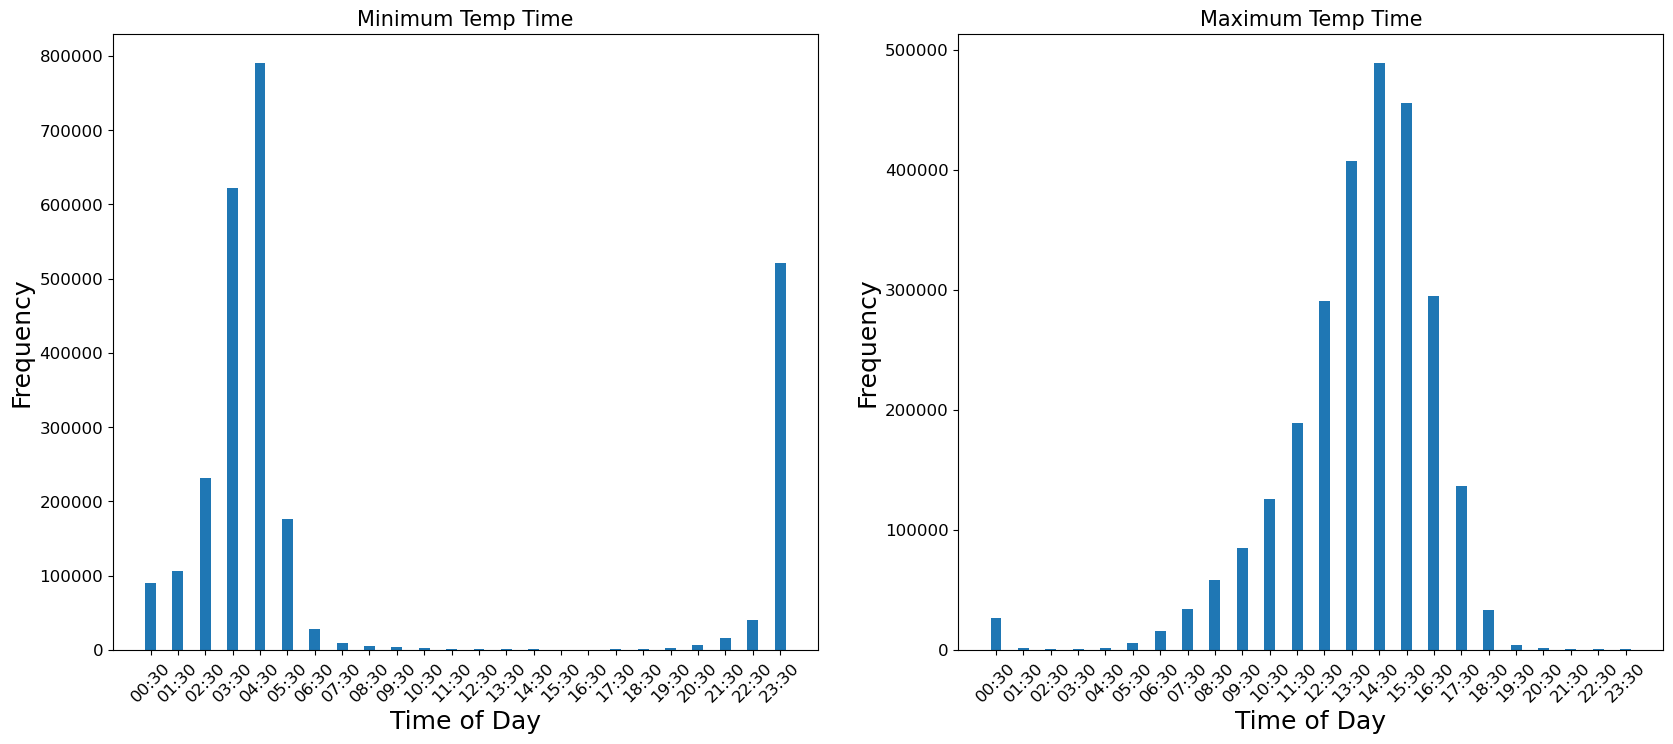

In [487]:
# create some plots of the times of day which the Tmins and Tmax occurs
min_time_count = min_netatmo_temp_humid_cleaned_gdf[['Time2','ID']].groupby('Time2').count().reset_index()
max_time_count = max_netatmo_temp_humid_cleaned_gdf[['Time2','ID']].groupby('Time2').count().reset_index()

fig, axes = plt.subplots(1,2, figsize = (20,8))
# Tmin
times3 = []
for time in min_time_count['Time2'].values:
    times3.append(time.strftime('%H:%M'))
axes[0].bar(times3, list(min_time_count.ID), width = 0.4)

axes[0].set(title = 'Minimum Temp Time', xlabel = 'Time of Day', ylabel = 'Frequency')
axes[0].tick_params(axis='x', labelrotation=45) # rotate the times, otherwise they overlap

#Tmax
times3 = []
for time in max_time_count['Time2'].values:
    times3.append(time.strftime('%H:%M'))
axes[1].bar(times3, list(max_time_count.ID), width = 0.4)
axes[1].set(title = 'Maximum Temp Time', xlabel = 'Time of Day', ylabel = 'Frequency')
axes[1].tick_params(axis='x', labelrotation=45) # rotate the times, otherwise they overlap

#save the plot
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','DDL' ,'Netatmo')) 
plt.savefig('TOD_Tmin_Tmax_netatmo.png')

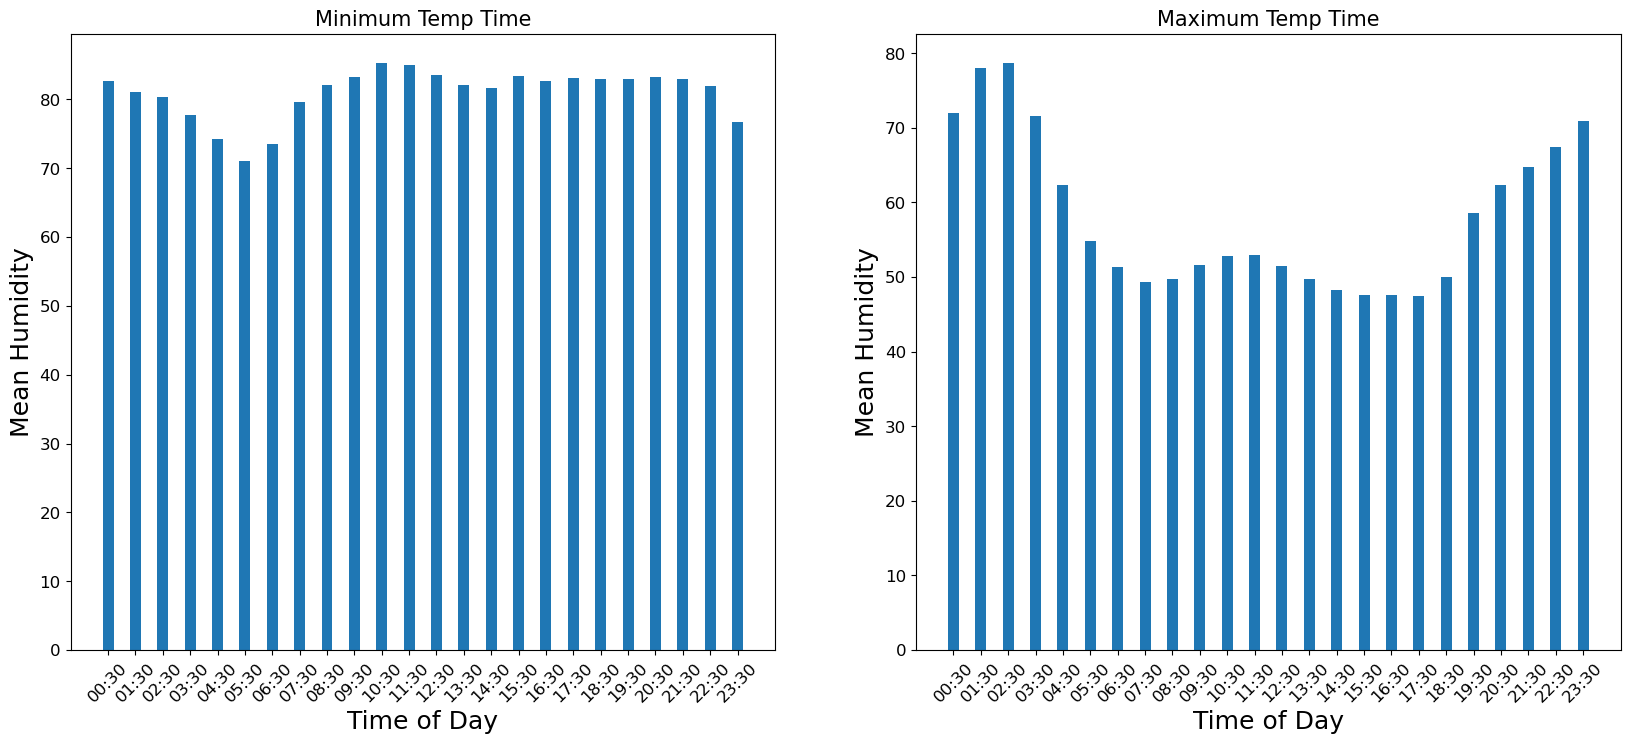

In [488]:
# create some plots of the corresponding humidity when the Tmins and Tmax occurs
min_T_mean_humidity = min_netatmo_temp_humid_cleaned_gdf[['Time2','Humidity']].groupby('Time2').mean().reset_index()
max_T_mean_humidity = max_netatmo_temp_humid_cleaned_gdf[['Time2','Humidity']].groupby('Time2').mean().reset_index()

fig, axes = plt.subplots(1,2, figsize = (20,8))
# Tmin
times3 = []
for time in min_time_count['Time2'].values:
    times3.append(time.strftime('%H:%M'))
axes[0].bar(times3, list(min_T_mean_humidity.Humidity), width = 0.4)

axes[0].set(title = 'Minimum Temp Time', xlabel = 'Time of Day', ylabel = 'Mean Humidity')
axes[0].tick_params(axis='x', labelrotation=45) # rotate the times, otherwise they overlap

#Tmax
times3 = []
for time in max_time_count['Time2'].values:
    times3.append(time.strftime('%H:%M'))
axes[1].bar(times3, list(max_T_mean_humidity.Humidity), width = 0.4)
axes[1].set(title = 'Maximum Temp Time', xlabel = 'Time of Day', ylabel = 'Mean Humidity')
axes[1].tick_params(axis='x', labelrotation=45) # rotate the times, otherwise they overlap


In [489]:
# Aggregate to monthly means
july_max_netatmo_temp_humid_cleaned_gdf = max_netatmo_temp_humid_cleaned_gdf[['ID','Lat','Lon','Humidity','Temperature']].groupby(['ID','Lat','Lon']
                                                                                                                            ).mean().reset_index()
july_min_netatmo_temp_humid_cleaned_gdf = min_netatmo_temp_humid_cleaned_gdf[['ID','Lat','Lon','Humidity','Temperature']].groupby(['ID','Lat','Lon']
                                                                                                                            ).mean().reset_index()
# have to put geometry back in as the grouping didn't like it! (takes < 1 sec though)
july_max_netatmo_temp_humid_cleaned_gdf = gpd.GeoDataFrame(july_max_netatmo_temp_humid_cleaned_gdf, 
                                    geometry = gpd.points_from_xy(july_max_netatmo_temp_humid_cleaned_gdf["Lon"], 
                                     july_max_netatmo_temp_humid_cleaned_gdf["Lat"]), crs="epsg:4326")

july_min_netatmo_temp_humid_cleaned_gdf = gpd.GeoDataFrame(july_min_netatmo_temp_humid_cleaned_gdf, 
                                    geometry = gpd.points_from_xy(july_min_netatmo_temp_humid_cleaned_gdf["Lon"], 
                                     july_min_netatmo_temp_humid_cleaned_gdf["Lat"]), crs="epsg:4326")


In [490]:
# Write the netatmo Tmin, Tmax gdfs to a shapefile for ee
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'DDL', 'Netatmo','Data','AirTempEVal'))
july_max_netatmo_temp_humid_cleaned_gdf.to_file('july_max_netatmo_temp_humid_cleaned_gdf.shp', driver='ESRI Shapefile')
july_min_netatmo_temp_humid_cleaned_gdf.to_file('july_min_netatmo_temp_humid_cleaned_gdf.shp', driver='ESRI Shapefile')

# after doing this, upload the shapefile to gee and run the CUHI_Netatmo code
# run netatmo_Tmax_pointsWithLandcover and netatmo_Tmin_pointsWithLandcover and download the files from google drive to the Netatmo data folder


C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_18176\2240514422.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  july_max_netatmo_temp_humid_cleaned_gdf.to_file('july_max_netatmo_temp_humid_cleaned_gdf.shp', driver='ESRI Shapefile')
C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_18176\2240514422.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  july_min_netatmo_temp_humid_cleaned_gdf.to_file('july_min_netatmo_temp_humid_cleaned_gdf.shp', driver='ESRI Shapefile')


In [13]:
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'DDL', 'Netatmo','Data'))
netatmo_Tmax_pointsWithLandcover = pd.read_csv('netatmo_Tmax_pointsWithLandcover.csv')
netatmo_Tmin_pointsWithLandcover = pd.read_csv('netatmo_Tmin_pointsWithLandcover.csv')

netatmo_Tmax_pointsWithLandcover_gdf = gpd.GeoDataFrame(netatmo_Tmax_pointsWithLandcover, 
                                    geometry = gpd.points_from_xy(netatmo_Tmax_pointsWithLandcover["Lon"], 
                                     netatmo_Tmax_pointsWithLandcover["Lat"]), crs="epsg:4326")

netatmo_Tmin_pointsWithLandcover_gdf = gpd.GeoDataFrame(netatmo_Tmin_pointsWithLandcover, 
                                    geometry = gpd.points_from_xy(netatmo_Tmin_pointsWithLandcover["Lon"], 
                                     netatmo_Tmin_pointsWithLandcover["Lat"]), crs="epsg:4326")

# get landcover types out of the list format
landcover_type_list = []
for i in range(len(netatmo_Tmax_pointsWithLandcover_gdf)):
    extracted = netatmo_Tmax_pointsWithLandcover_gdf['landcover_type'].iloc[i][1:3]
    landcover_type_list.append(extracted)

netatmo_Tmax_pointsWithLandcover_gdf['landcover_type'] = landcover_type_list

landcover_type_list = []
for i in range(len(netatmo_Tmin_pointsWithLandcover_gdf)):
    extracted = netatmo_Tmin_pointsWithLandcover_gdf['landcover_type'].iloc[i][1:3]
    landcover_type_list.append(extracted)

netatmo_Tmin_pointsWithLandcover_gdf['landcover_type'] = landcover_type_list

In [14]:
# Add in the description of the landcover
landcover_type_key = {'10':'Tree cover','20': 'Shrubland','30': 'Grassland','40': 'Cropland','50': 'Built-up','60': 'Bare / sparse vegetation',
                    '70': 'Snow and ice','80': 'Permanent water bodies','90': 'Herbaceous wetland','95': 'Mangroves','100': 'Moss and lichen'}

netatmo_Tmax_pointsWithLandcover_gdf['Landcover_Desc'] = netatmo_Tmax_pointsWithLandcover_gdf['landcover_type'].map(landcover_type_key)
netatmo_Tmin_pointsWithLandcover_gdf['Landcover_Desc'] = netatmo_Tmin_pointsWithLandcover_gdf['landcover_type'].map(landcover_type_key)

(0.0, 32.0)

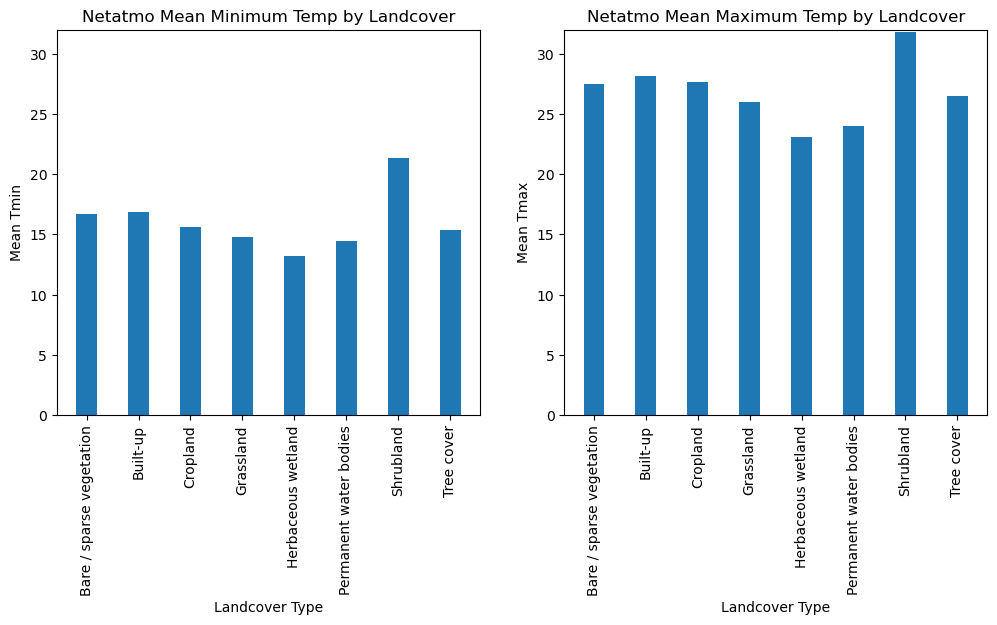

In [15]:
# create some plots of the Tmax and Tmin for the landcover types 
Tmin_mean_landcover = netatmo_Tmin_pointsWithLandcover_gdf[['Landcover_Desc','Temperatur']].groupby('Landcover_Desc').mean().reset_index()
Tmax_mean_landcover = netatmo_Tmax_pointsWithLandcover_gdf[['Landcover_Desc','Temperatur']].groupby('Landcover_Desc').mean().reset_index()

fig, axes = plt.subplots(1,2, figsize = (12,5))
# Tmin
axes[0].bar(Tmin_mean_landcover.Landcover_Desc, Tmin_mean_landcover.Temperatur, width = 0.4)

axes[0].set(title = 'Netatmo Mean Minimum Temp by Landcover', xlabel = 'Landcover Type', ylabel = 'Mean Tmin')
axes[0].tick_params(axis='x', labelrotation=90) # rotate the times, otherwise they overlap
axes[0].set_ylim([0, 32])
#Tmax
axes[1].bar(Tmax_mean_landcover.Landcover_Desc, Tmax_mean_landcover.Temperatur, width = 0.4)
axes[1].set(title = 'Netatmo Mean Maximum Temp by Landcover', xlabel = 'Landcover Type', ylabel = 'Mean Tmax')
axes[1].tick_params(axis='x', labelrotation=90) # rotate the times, otherwise they overlap
axes[1].set_ylim([0, 32])

In [16]:
# CUHIs created in earth engine from GDAT
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'DDL', 'Netatmo','Data'))
CUHI_cities_july2019_df = pd.read_csv('CUHI_cities_july2019.csv')

# Add in geometries for polygon shapes in the CUHI cities ee table 
shapefiles = pd.DataFrame()
for i in CUHI_cities_july2019_df['.geo'].values:
    shapefile = gpd.read_file(i)
    shapefiles = pd.concat([shapefiles, shapefile])

CUHI_cities_july2019_df['geometry'] = shapefiles.geometry.values

# create geopandas df
CUHI_cities_july2019_gdf = gpd.GeoDataFrame(CUHI_cities_july2019_df)

#join the GDAT data onto the netatmo
Tmax_gdf = gpd.sjoin(netatmo_Tmax_pointsWithLandcover_gdf,CUHI_cities_july2019_gdf,how="inner", predicate='intersects')
Tmin_gdf = gpd.sjoin(netatmo_Tmin_pointsWithLandcover_gdf,CUHI_cities_july2019_gdf,how="inner", predicate='intersects')

# remove the non urban landcovers
# built up landcover type code is 50
Tmax_urban_gdf = Tmax_gdf[Tmax_gdf.landcover_type == '50']
Tmin_urban_gdf = Tmin_gdf[Tmin_gdf.landcover_type == '50']

# the rural areas within the neighborhoods
# everything apart from urban tiles
Tmax_rural_gdf = Tmax_gdf[Tmax_gdf.landcover_type != '50']
Tmin_rural_gdf = Tmin_gdf[Tmin_gdf.landcover_type != '50']

[Text(0.5, 1.0, 'Number of Netatmo Points in Neighborhoods (Tmax)'),
 Text(0.5, 0, 'Number of Stations in Neighborhood'),
 Text(0, 0.5, 'Number of Neigborhoods')]

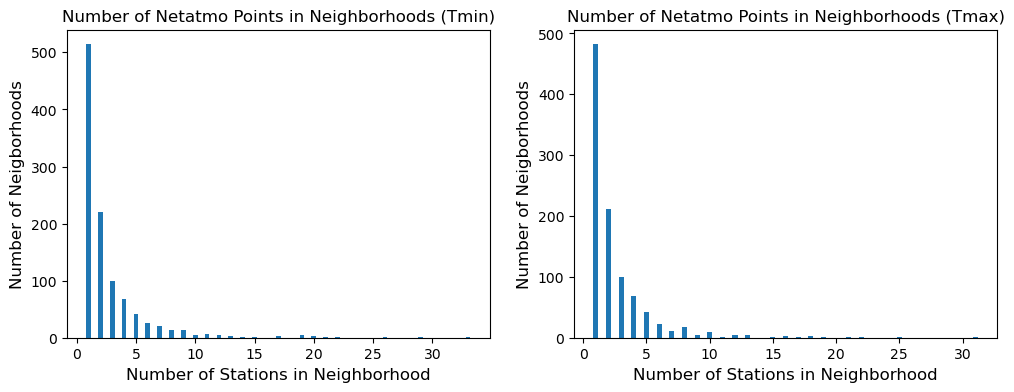

In [116]:
## Show the number of netatmo stations in each neighborhood- most neighborhoods only have one 
#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title


nbhd_station_count_Tmax = Tmax_urban_gdf[['nbhd_code','ID']].groupby('nbhd_code').count().reset_index()
tmax_num_netatmo_per_nbhd = nbhd_station_count_Tmax['ID'].value_counts().reset_index().rename(columns = {'index': 'num_stations', 'ID': 'Frequency'})

nbhd_station_count_Tmin = Tmin_urban_gdf[['nbhd_code','ID']].groupby('nbhd_code').count().reset_index()
tmin_num_netatmo_per_nbhd = nbhd_station_count_Tmin['ID'].value_counts().reset_index().rename(columns = {'index': 'num_stations', 'ID': 'Frequency'})

fig, axes = plt.subplots(1,2, figsize = (12,4))
# Tmin
axes[0].bar(tmin_num_netatmo_per_nbhd.num_stations, tmin_num_netatmo_per_nbhd.Frequency, width = 0.4)
axes[0].set(title = 'Number of Netatmo Points in Neighborhoods (Tmin)', xlabel = 'Number of Stations in Neighborhood', ylabel = 'Number of Neigborhoods')
#Tmax
axes[1].bar(tmax_num_netatmo_per_nbhd.num_stations, tmax_num_netatmo_per_nbhd.Frequency, width = 0.4)
axes[1].set(title = 'Number of Netatmo Points in Neighborhoods (Tmax)', xlabel = 'Number of Stations in Neighborhood', ylabel = 'Number of Neigborhoods')

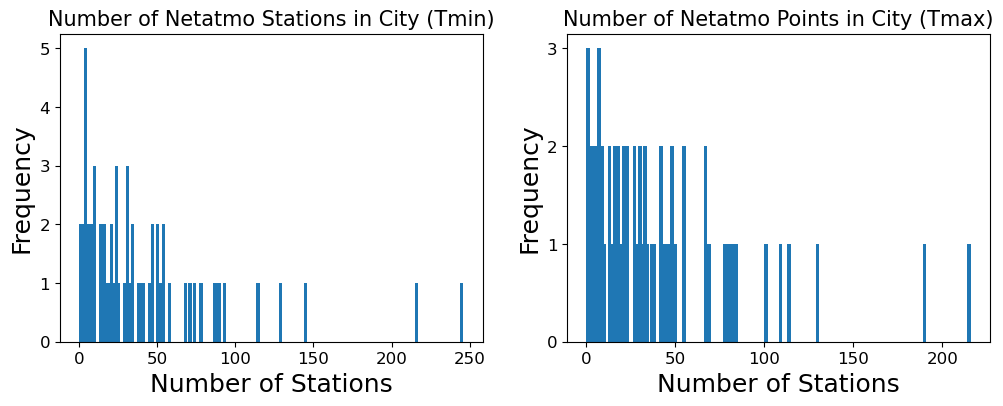

In [146]:
## Show the number of netatmo stations in each city-

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=15)  # fontsize of the figure title

city_station_count_Tmax = Tmax_urban_gdf[['uesi_id','ID']].groupby('uesi_id').count().reset_index()
tmax_num_netatmo_per_city = city_station_count_Tmax['ID'].value_counts().reset_index(
                            ).rename(columns = {'index': 'num_stations', 'ID': 'Frequency'}).sort_values(by ='num_stations')

city_station_count_Tmin = Tmin_urban_gdf[['uesi_id','ID']].groupby('uesi_id').count().reset_index()
tmin_num_netatmo_per_city = city_station_count_Tmin['ID'].value_counts().reset_index(
                            ).rename(columns = {'index': 'num_stations', 'ID': 'Frequency'}).sort_values(by ='num_stations')

fig, axes = plt.subplots(1,2, figsize = (12,4))
# Tmin
axes[0].bar(tmin_num_netatmo_per_city.num_stations.values, tmin_num_netatmo_per_city.Frequency.values, width = 2)
axes[0].set(title = 'Number of Netatmo Stations in City (Tmin)', xlabel = 'Number of Stations', ylabel = 'Frequency')
#Tmax
axes[1].bar(tmax_num_netatmo_per_city.num_stations, tmax_num_netatmo_per_city.Frequency, width = 2)
axes[1].set(title = 'Number of Netatmo Points in City (Tmax)', xlabel = 'Number of Stations', ylabel = 'Frequency')
from matplotlib.ticker import MaxNLocator
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
#Berlin - DEU_R62422 has the highest number of total netatmo stations- 215 for Tmax and 245 for Tmin

In [21]:
# group so the data is at neighborhood level
#maximum temp
T_max_comparison_df = Tmax_urban_gdf[['nbhd_code','nbhd_name','uesi_id','Temperatur','Humidity','July_Urban_T_Max_GDAT']].groupby(
                                                                    ['nbhd_code','nbhd_name','uesi_id']).mean().reset_index()

T_max_comparison_df = T_max_comparison_df[~np.isnan(T_max_comparison_df.July_Urban_T_Max_GDAT)].reset_index() #remove GDAT nan (101 Reykjavik)
#minimum temp
T_min_comparison_df = Tmin_urban_gdf[['nbhd_code','nbhd_name','uesi_id','Temperatur','Humidity','July_Urban_T_Min_GDAT']].groupby(
                                                                    ['nbhd_code','nbhd_name','uesi_id']).mean().reset_index()
T_min_comparison_df = T_min_comparison_df[~np.isnan(T_min_comparison_df.July_Urban_T_Min_GDAT)].reset_index() #remove GDAT nan (101 Reykjavik)

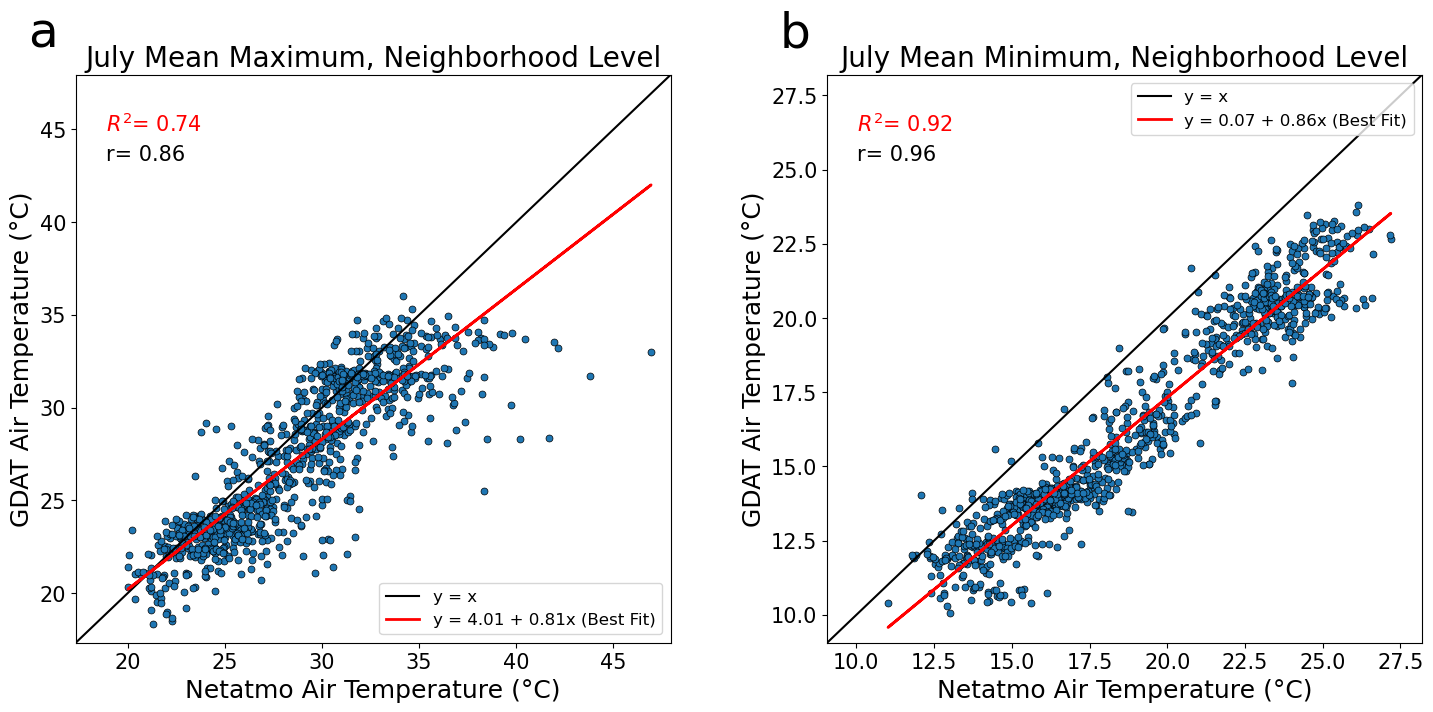

In [22]:
# compare the netatmo Tmax, Tmin with the GDAT Tmax, Tmin

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,2, figsize = (16, 8))
fig.tight_layout(pad=7.0)
# Tmax
netatmo_temp = T_max_comparison_df.Temperatur
GDAT_temp = T_max_comparison_df.July_Urban_T_Max_GDAT

axes[0].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
axes[0].set(title = 'July Mean Maximum, Neighborhood Level', 
         xlabel = 'Netatmo Air Temperature (\u00b0C)', ylabel = 'GDAT Air Temperature (\u00b0C)')

axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

axes[0].set_xlim([axesmin, axesmax])
axes[0].set_ylim([axesmin, axesmax])
# x = y line
axes[0].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

#get the intercept/ slope of best fit line and prediction interval
sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
b = sm_model.params.iloc[0]
a = sm_model.params.iloc[1]
sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

axes[0].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

#text labels
axes[0].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=15,color ='red', transform=axes[0].transAxes)
axes[0].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=15, transform=axes[0].transAxes)

axes[0].legend(loc = 4)

# Tmin
netatmo_temp = T_min_comparison_df.Temperatur
GDAT_temp = T_min_comparison_df.July_Urban_T_Min_GDAT

axes[1].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
axes[1].set(title = 'July Mean Minimum, Neighborhood Level', 
         xlabel = 'Netatmo Air Temperature (\u00b0C)', ylabel = 'GDAT Air Temperature (\u00b0C)')

axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

axes[1].set_xlim([axesmin, axesmax])
axes[1].set_ylim([axesmin, axesmax])
# x = y line
axes[1].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

#get the intercept/ slope of best fit line and prediction interval
sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
b = sm_model.params.iloc[0]
a = sm_model.params.iloc[1]
sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

axes[1].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

#text labels
axes[1].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=15,color ='red', transform=axes[1].transAxes)
axes[1].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=15, transform=axes[1].transAxes)

axes[1].legend(loc = 1)

#add letters for figs
axes[0].text(-0.08, 1.05, 'a', fontsize=35, transform=axes[0].transAxes)
axes[1].text(-0.08, 1.05, 'b', fontsize=35, transform=axes[1].transAxes)

#save the plot
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','DDL' ,'Netatmo')) 
plt.savefig('netatmo_vs_GDAT_scatter.png', bbox_inches="tight",dpi=800)# dpi increased to give better quality image, but does take longer to save

Text(-0.08, 1.05, 'b')

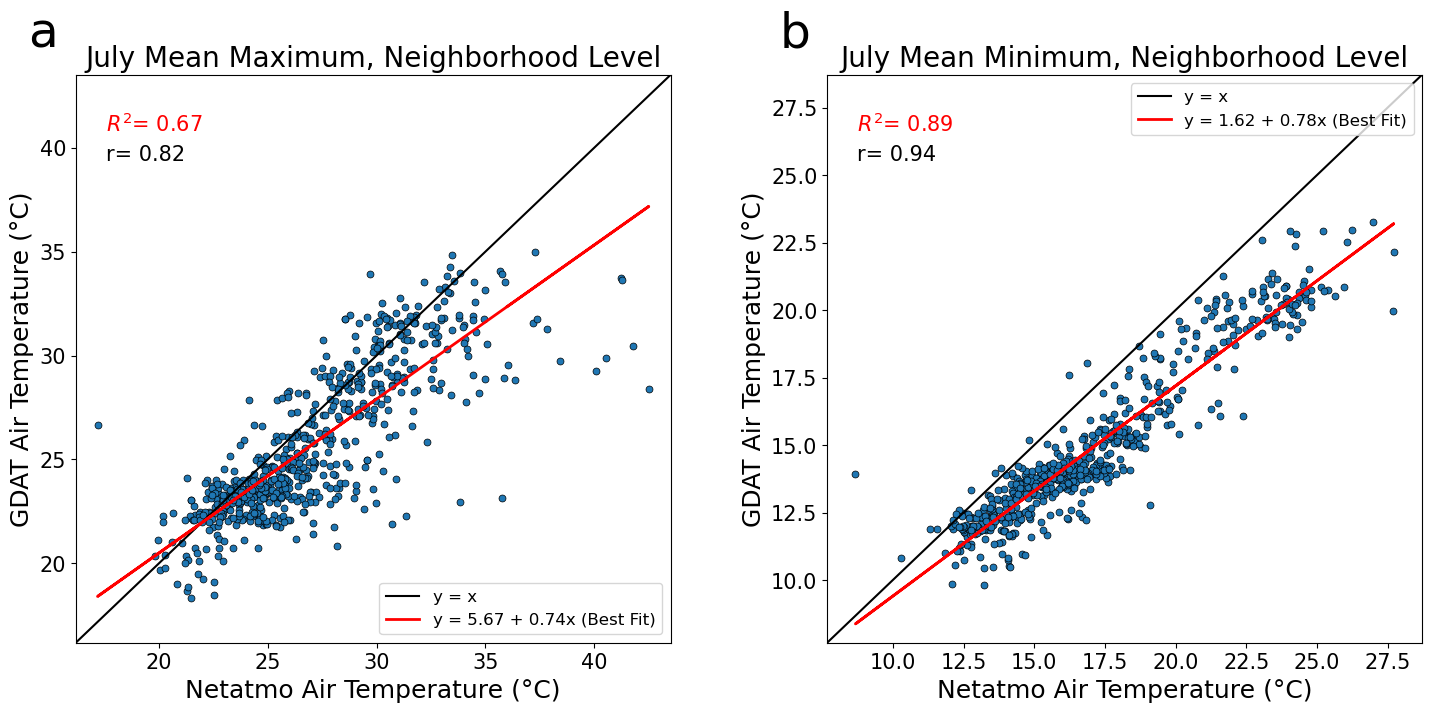

In [23]:
# compare the rural temperatures
# group so the data is at neighborhood level
#maximum temp
rural_T_max_comparison_df = Tmax_rural_gdf[['nbhd_code','nbhd_name','uesi_id','Temperatur','Humidity','July_Urban_T_Max_GDAT']].groupby(
                                                                    ['nbhd_code','nbhd_name','uesi_id']).mean().reset_index()

#T_max_comparison_df = T_max_comparison_df[~np.isnan(T_max_comparison_df.July_Urban_T_Max_GDAT)].reset_index() #remove GDAT nan (101 Reykjavik)
#minimum temp
rural_T_min_comparison_df = Tmin_rural_gdf[['nbhd_code','nbhd_name','uesi_id','Temperatur','Humidity','July_Urban_T_Min_GDAT']].groupby(
                                                                    ['nbhd_code','nbhd_name','uesi_id']).mean().reset_index()

#T_min_comparison_df = T_min_comparison_df[~np.isnan(T_min_comparison_df.July_Urban_T_Min_GDAT)].reset_index() #remove GDAT nan (101 Reykjavik)

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,2, figsize = (16, 8))
fig.tight_layout(pad=7.0)
# Tmax
netatmo_temp = rural_T_max_comparison_df.Temperatur
GDAT_temp = rural_T_max_comparison_df.July_Urban_T_Max_GDAT

axes[0].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
axes[0].set(title = 'July Mean Maximum, Neighborhood Level', 
         xlabel = 'Netatmo Air Temperature (\u00b0C)', ylabel = 'GDAT Air Temperature (\u00b0C)')

axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

axes[0].set_xlim([axesmin, axesmax])
axes[0].set_ylim([axesmin, axesmax])
# x = y line
axes[0].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

#get the intercept/ slope of best fit line and prediction interval
sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
b = sm_model.params.iloc[0]
a = sm_model.params.iloc[1]
sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

axes[0].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

#text labels
axes[0].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=15,color ='red', transform=axes[0].transAxes)
axes[0].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=15, transform=axes[0].transAxes)

axes[0].legend(loc = 4)

# Tmin
netatmo_temp = rural_T_min_comparison_df.Temperatur
GDAT_temp = rural_T_min_comparison_df.July_Urban_T_Min_GDAT

axes[1].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
axes[1].set(title = 'July Mean Minimum, Neighborhood Level', 
         xlabel = 'Netatmo Air Temperature (\u00b0C)', ylabel = 'GDAT Air Temperature (\u00b0C)')

axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

axes[1].set_xlim([axesmin, axesmax])
axes[1].set_ylim([axesmin, axesmax])
# x = y line
axes[1].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

#get the intercept/ slope of best fit line and prediction interval
sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
b = sm_model.params.iloc[0]
a = sm_model.params.iloc[1]
sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

axes[1].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

#text labels
axes[1].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=15,color ='red', transform=axes[1].transAxes)
axes[1].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=15, transform=axes[1].transAxes)

axes[1].legend(loc = 1)

#add letters for figs
axes[0].text(-0.08, 1.05, 'a', fontsize=35, transform=axes[0].transAxes)
axes[1].text(-0.08, 1.05, 'b', fontsize=35, transform=axes[1].transAxes)

In [24]:
# add in the climate data
T_max_comparison_df = T_max_comparison_df.merge(climate_zone[['uesi_id','Code']], how = 'left', on = 'uesi_id')
T_min_comparison_df = T_min_comparison_df.merge(climate_zone[['uesi_id','Code']], how = 'left', on = 'uesi_id')


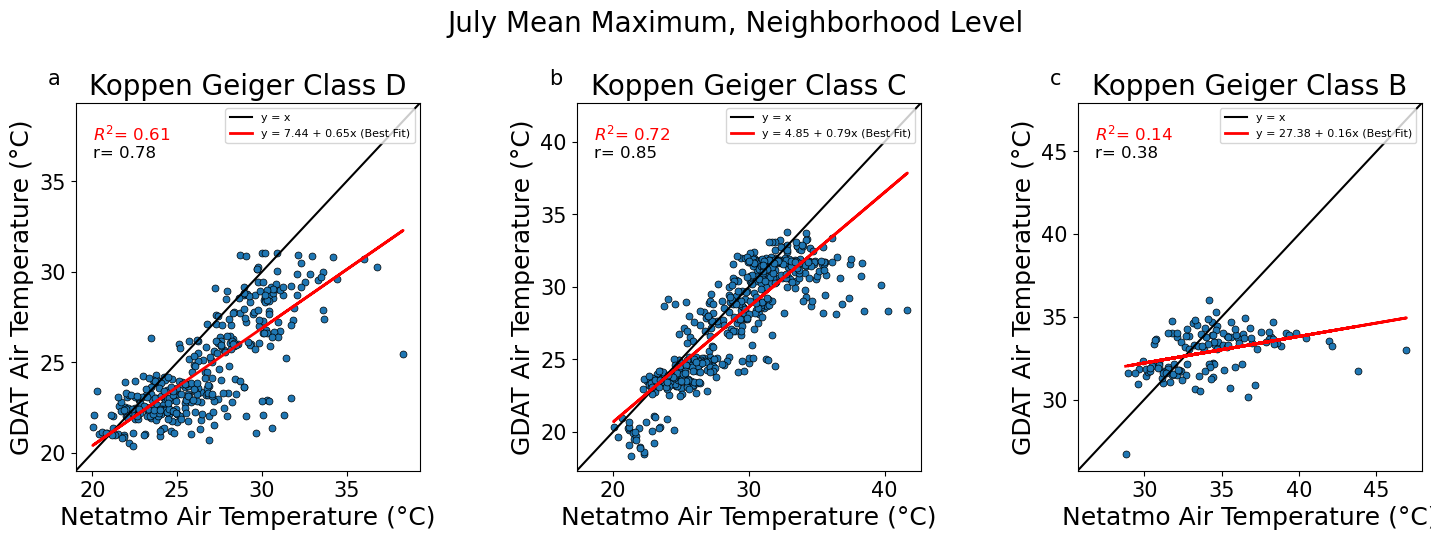

In [25]:
# create plots split into koppen geiger climate classifications

######################
##### MAX TEMP #######
######################

# add in the climate data
#T_max_comparison_df = T_max_comparison_df.merge(climate_zone[['uesi_id','Code']], how = 'left', on = 'uesi_id')
# add in single/double letter classifications
T_max_comparison_df['Single_letter_CC'] = T_max_comparison_df['Code'].astype(str).str[0]
T_max_comparison_df['Double_letter_CC'] = T_max_comparison_df['Code'].astype(str).str[0:2]
# Plot

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,3, figsize = (16, 6))
fig.tight_layout(pad=7.0)
fig.suptitle('July Mean Maximum, Neighborhood Level')
# Tmax
row_num = 0
labels = ['a','b','c']
for clim_class in set(T_max_comparison_df.Single_letter_CC):
    netatmo_temp = T_max_comparison_df[T_max_comparison_df.Single_letter_CC == clim_class].Temperatur
    GDAT_temp = T_max_comparison_df[T_max_comparison_df.Single_letter_CC == clim_class].July_Urban_T_Max_GDAT

    axes[row_num].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
    axes[row_num].set(title = 'Koppen Geiger Class {}'.format(clim_class), 
        xlabel = 'Netatmo Air Temperature (\u00b0C)', ylabel = 'GDAT Air Temperature (\u00b0C)')

    axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
    axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

    axes[row_num].set_xlim([axesmin, axesmax])
    axes[row_num].set_ylim([axesmin, axesmax])
    # x = y line
    axes[row_num].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

    #get the intercept/ slope of best fit line and prediction interval
    sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
    b = sm_model.params.iloc[0]
    a = sm_model.params.iloc[1]
    sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

    axes[row_num].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

    #text labels
    axes[row_num].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=12,color ='red', 
                         transform=axes[row_num].transAxes)
    axes[row_num].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=12, 
                         transform=axes[row_num].transAxes)

    axes[row_num].legend(loc = 1)
    axes[row_num].text(-0.08, 1.05, labels[row_num], fontsize=15, transform=axes[row_num].transAxes)
    row_num = row_num +1
    
#save the plot
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','DDL' ,'Netatmo')) 
plt.savefig('climate_class_Tmax_netatmo_vs_GDAT_scatter.png', bbox_inches="tight",dpi=800)
    # dpi increased to give better quality image, but does take longer to save

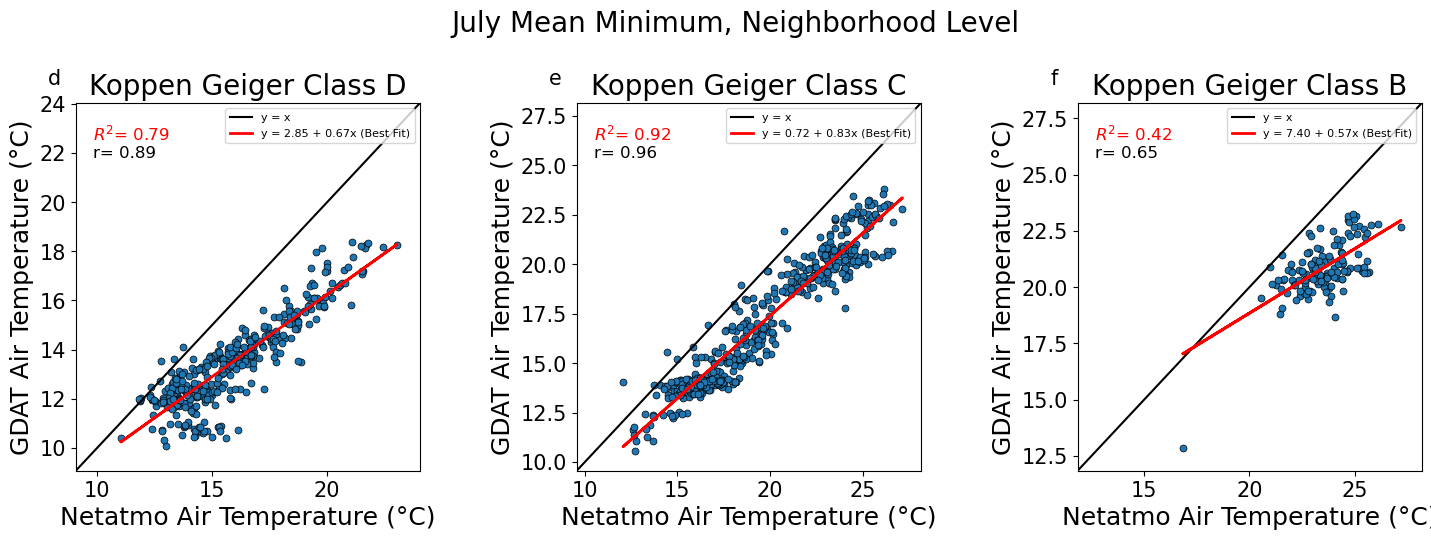

In [26]:
# create plots split into koppen geiger climate classifications

######################
##### MIN TEMP #######
######################

# add in the climate data
#T_min_comparison_df = T_min_comparison_df.merge(climate_zone[['uesi_id','Code']], how = 'left', on = 'uesi_id')
# add in single/double letter classifications
T_min_comparison_df['Single_letter_CC'] = T_min_comparison_df['Code'].astype(str).str[0]
T_min_comparison_df['Double_letter_CC'] = T_min_comparison_df['Code'].astype(str).str[0:2]
# Plot

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,3, figsize = (16, 6))
fig.tight_layout(pad=7.0)
fig.suptitle('July Mean Minimum, Neighborhood Level')
# Tmax
row_num = 0
#labels = ['a','b','c']
labels = ['d','e','f']
for clim_class in set(T_min_comparison_df.Single_letter_CC):
    netatmo_temp = T_min_comparison_df[T_min_comparison_df.Single_letter_CC == clim_class].Temperatur
    GDAT_temp = T_min_comparison_df[T_min_comparison_df.Single_letter_CC == clim_class].July_Urban_T_Min_GDAT

    axes[row_num].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
    axes[row_num].set(title = 'Koppen Geiger Class {}'.format(clim_class), 
        xlabel = 'Netatmo Air Temperature (\u00b0C)', ylabel = 'GDAT Air Temperature (\u00b0C)')

    axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
    axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

    axes[row_num].set_xlim([axesmin, axesmax])
    axes[row_num].set_ylim([axesmin, axesmax])
    # x = y line
    axes[row_num].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

    #get the intercept/ slope of best fit line and prediction interval
    sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
    b = sm_model.params.iloc[0]
    a = sm_model.params.iloc[1]
    sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

    axes[row_num].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

    #text labels
    axes[row_num].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=12,color ='red', 
                         transform=axes[row_num].transAxes)
    axes[row_num].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=12, 
                         transform=axes[row_num].transAxes)

    axes[row_num].legend(loc = 1)
    axes[row_num].text(-0.08, 1.05, labels[row_num], fontsize=15, transform=axes[row_num].transAxes)
    row_num = row_num +1
    
#save the plot
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','DDL' ,'Netatmo')) 
plt.savefig('climate_class_TmIN_netatmo_vs_GDAT_scatter.png', bbox_inches="tight",dpi=800)
    # dpi increased to give better quality image, but does take longer to save

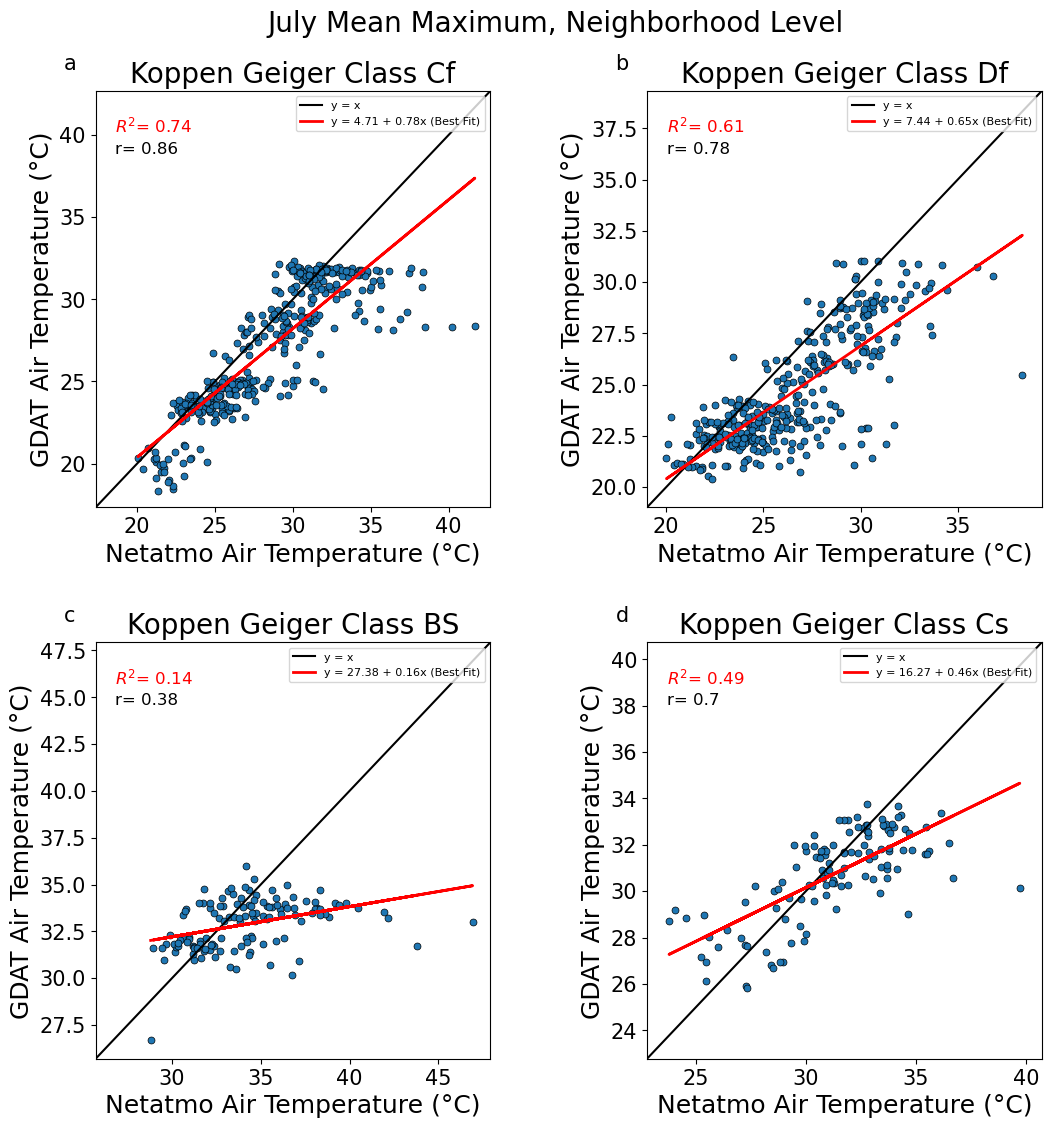

In [27]:
# create plots split into koppen geiger climate classifications

###### Two Letter Koppen Geiger ######

######################
##### MAX TEMP #######
######################

# add in the climate data
#T_max_comparison_df = T_max_comparison_df.merge(climate_zone[['uesi_id','Code']], how = 'left', on = 'uesi_id')
# add in single/double letter classifications
T_max_comparison_df['Single_letter_CC'] = T_max_comparison_df['Code'].astype(str).str[0]
T_max_comparison_df['Double_letter_CC'] = T_max_comparison_df['Code'].astype(str).str[0:2]
# Plot

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2,2, figsize = (12, 12))
fig.tight_layout(pad=7.0)
fig.suptitle('July Mean Maximum, Neighborhood Level')
# Tmax
row_num = 0
col_num = 0
label_num = 0
labels = ['a','b','c','d']
for clim_class in set(T_max_comparison_df.Double_letter_CC):
    netatmo_temp = T_max_comparison_df[T_max_comparison_df.Double_letter_CC == clim_class].Temperatur
    GDAT_temp = T_max_comparison_df[T_max_comparison_df.Double_letter_CC == clim_class].July_Urban_T_Max_GDAT

    row_num = label_num%2
    if label_num < 2: col_num = 0 
    else: col_num = 1
    
    axes[col_num, row_num].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
    axes[col_num, row_num].set(title = 'Koppen Geiger Class {}'.format(clim_class), 
        xlabel = 'Netatmo Air Temperature (\u00b0C)', ylabel = 'GDAT Air Temperature (\u00b0C)')

    axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
    axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

    axes[col_num, row_num].set_xlim([axesmin, axesmax])
    axes[col_num, row_num].set_ylim([axesmin, axesmax])
    # x = y line
    axes[col_num, row_num].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

    #get the intercept/ slope of best fit line and prediction interval
    sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
    b = sm_model.params.iloc[0]
    a = sm_model.params.iloc[1]
    sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

    axes[col_num, row_num].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

    #text labels
    axes[col_num, row_num].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=12,color ='red', 
                         transform=axes[col_num, row_num].transAxes)
    axes[col_num, row_num].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=12, 
                         transform=axes[col_num, row_num].transAxes)

    axes[col_num, row_num].legend(loc = 1)
    axes[col_num, row_num].text(-0.08, 1.05, labels[label_num], fontsize=15, transform=axes[col_num, row_num].transAxes)
    label_num = label_num+1
    
#save the plot
#os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','DDL' ,'Netatmo')) 
#plt.savefig('climate_class_Tmax_netatmo_vs_GDAT_scatter.png', bbox_inches="tight",dpi=800)
    # dpi increased to give better quality image, but does take longer to save

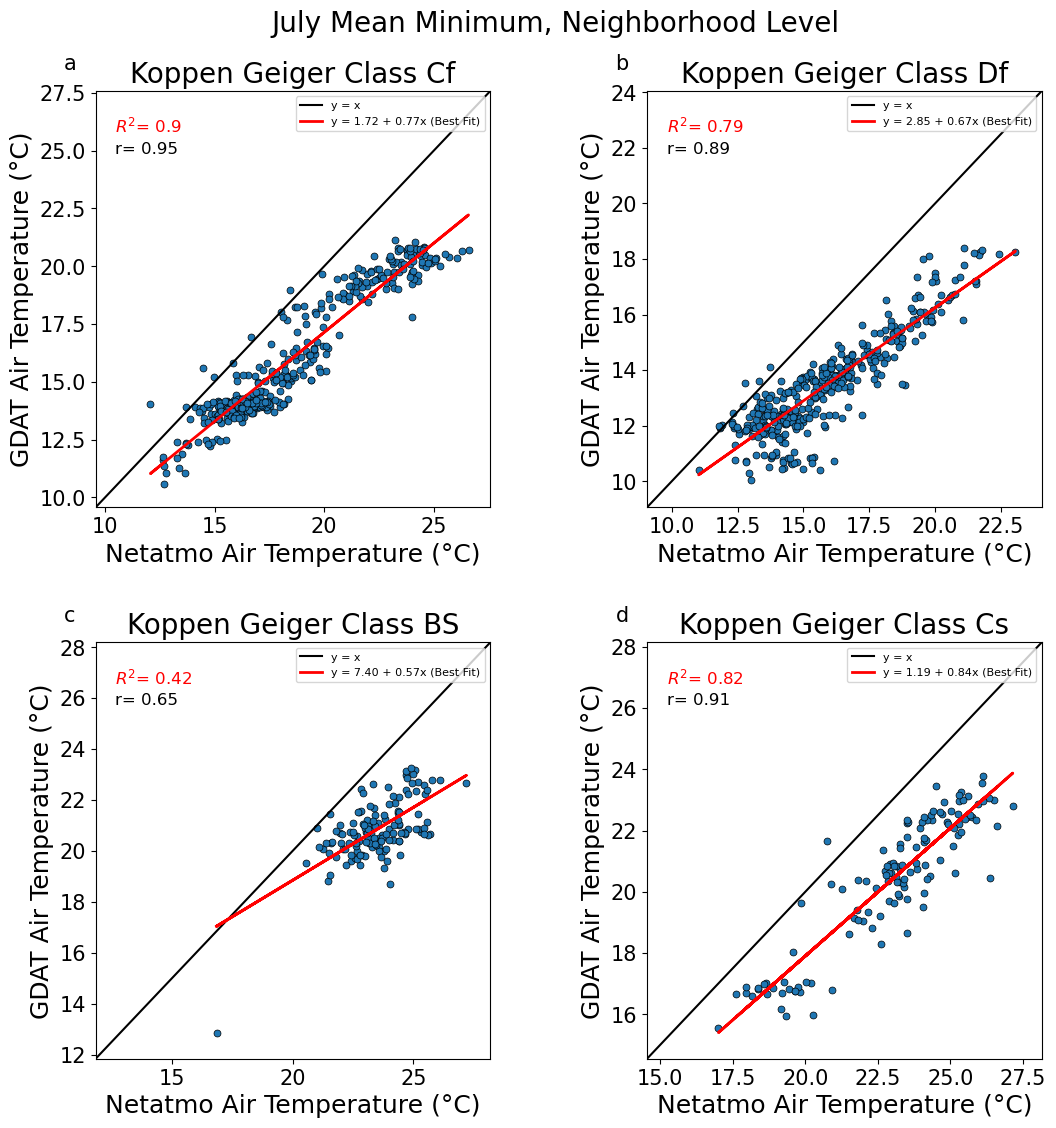

In [28]:
# create plots split into koppen geiger climate classifications

###### Two Letter Koppen Geiger ######

######################
##### MIN TEMP #######
######################

# Plot

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2,2, figsize = (12, 12))
fig.tight_layout(pad=7.0)
fig.suptitle('July Mean Minimum, Neighborhood Level')
# Tmax
row_num = 0
col_num = 0
label_num = 0
labels = ['a','b','c','d']
for clim_class in set(T_min_comparison_df.Double_letter_CC):
    netatmo_temp = T_min_comparison_df[T_min_comparison_df.Double_letter_CC == clim_class].Temperatur
    GDAT_temp = T_min_comparison_df[T_min_comparison_df.Double_letter_CC == clim_class].July_Urban_T_Min_GDAT

    row_num = label_num%2
    if label_num < 2: col_num = 0 
    else: col_num = 1
    
    axes[col_num, row_num].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
    axes[col_num, row_num].set(title = 'Koppen Geiger Class {}'.format(clim_class), 
        xlabel = 'Netatmo Air Temperature (\u00b0C)', ylabel = 'GDAT Air Temperature (\u00b0C)')

    axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
    axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

    axes[col_num, row_num].set_xlim([axesmin, axesmax])
    axes[col_num, row_num].set_ylim([axesmin, axesmax])
    # x = y line
    axes[col_num, row_num].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

    #get the intercept/ slope of best fit line and prediction interval
    sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
    b = sm_model.params.iloc[0]
    a = sm_model.params.iloc[1]
    sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

    axes[col_num, row_num].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

    #text labels
    axes[col_num, row_num].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=12,color ='red', 
                         transform=axes[col_num, row_num].transAxes)
    axes[col_num, row_num].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=12, 
                         transform=axes[col_num, row_num].transAxes)

    axes[col_num, row_num].legend(loc = 1)
    axes[col_num, row_num].text(-0.08, 1.05, labels[label_num], fontsize=15, transform=axes[col_num, row_num].transAxes)
    label_num = label_num+1
    
#save the plot
#os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','DDL' ,'Netatmo')) 
#plt.savefig('climate_class_Tmax_netatmo_vs_GDAT_scatter.png', bbox_inches="tight",dpi=800)
    # dpi increased to give better quality image, but does take longer to save

In [29]:
## Look at comparisons of the overall (non neighborhood level) CUHIs

# Get the netatmo temperatures of the rural reference area
# Defined as the 10km buffer region surronding the city

os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'DDL', 'Netatmo','Data'))
donut_buffers10km = pd.read_csv('donutbuffer10km.csv')
# Add in geometries for polygon shapes in the CUHI cities ee table 
shapefiles = pd.DataFrame()
for i in donut_buffers10km['.geo'].values:
    shapefile = gpd.read_file(i)
    shapefiles = pd.concat([shapefiles, shapefile])

donut_buffers10km['geometry'] = shapefiles.geometry.values

# create geopandas df
donut_buffers10km_gdf = gpd.GeoDataFrame(donut_buffers10km)

#join the buffers onto the netatmo
rural_buffers_Tmax_gdf = gpd.sjoin(netatmo_Tmax_pointsWithLandcover_gdf,donut_buffers10km_gdf,how="inner", predicate='intersects')
rural_buffers_Tmin_gdf = gpd.sjoin(netatmo_Tmin_pointsWithLandcover_gdf,donut_buffers10km_gdf,how="inner", predicate='intersects')

# remove any urban areas from the buffer
# built up landcover type code is 50
rural_buffers_Tmax_gdf = rural_buffers_Tmax_gdf[rural_buffers_Tmax_gdf.landcover_type != '50']
rural_buffers_Tmin_gdf = rural_buffers_Tmin_gdf[rural_buffers_Tmin_gdf.landcover_type != '50']

In [30]:
# Get the netatmo temperatures of the cities 
# defined by the urban areas of the urban_dis UESI cities

os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'DDL', 'Netatmo','Data'))
urban_diss = pd.read_csv('urban_diss.csv')
# Add in geometries for polygon shapes in the CUHI cities ee table 
shapefiles = pd.DataFrame()
for i in urban_diss['.geo'].values:
    shapefile = gpd.read_file(i)
    shapefiles = pd.concat([shapefiles, shapefile])

urban_diss['geometry'] = shapefiles.geometry.values

# create geopandas df
urban_diss_gdf = gpd.GeoDataFrame(urban_diss)

#join the buffers onto the netatmo
urban_diss_Tmax_gdf = gpd.sjoin(netatmo_Tmax_pointsWithLandcover_gdf,urban_diss_gdf,how="inner", predicate='intersects')
urban_diss_Tmin_gdf = gpd.sjoin(netatmo_Tmin_pointsWithLandcover_gdf,urban_diss_gdf,how="inner", predicate='intersects')

# remove any nonurban areas in the city boundaries
# built up landcover type code is 50
urban_diss_Tmax_gdf = urban_diss_Tmax_gdf[urban_diss_Tmax_gdf.landcover_type == '50']
urban_diss_Tmin_gdf = urban_diss_Tmin_gdf[urban_diss_Tmin_gdf.landcover_type == '50']

In [31]:
# get netatmo CUHI for Tmax
# at the city level so the temperature and humidity are grouped at the city level

rural_df = rural_buffers_Tmax_gdf[['uesi_id','Temperatur','Humidity']].groupby(
                                'uesi_id').mean().reset_index()

rural_df = rural_df.rename(columns = {'Temperatur': 'Rural_Tmax', 'Humidity': 'Rural_Humidity_atTmax'})

urban_df = urban_diss_Tmax_gdf[['uesi_id','Temperatur','Humidity']].groupby(
                                'uesi_id').mean().reset_index()

urban_df = urban_df.rename(columns = {'Temperatur': 'Urban_Tmax', 'Humidity': 'Urban_Humidity_atTmax'})

netatmo_CUHI_Tmax_df = urban_df.merge(rural_df, how = 'inner', on = ['uesi_id'])
netatmo_CUHI_Tmax_df['CUHI_Tmax'] = netatmo_CUHI_Tmax_df.Urban_Tmax - netatmo_CUHI_Tmax_df.Rural_Tmax
netatmo_CUHI_Tmax_df['Humidity_Diff_Tmax'] = netatmo_CUHI_Tmax_df.Urban_Humidity_atTmax - netatmo_CUHI_Tmax_df.Rural_Humidity_atTmax

# get netatmo CUHI for Tmin
rural_df = rural_buffers_Tmin_gdf[['uesi_id','Temperatur','Humidity']].groupby(
                                    ['uesi_id']).mean().reset_index()

rural_df = rural_df.rename(columns = {'Temperatur': 'Rural_Tmin', 'Humidity': 'Rural_Humidity_atTmin'})

urban_df = urban_diss_Tmin_gdf[['uesi_id','Temperatur','Humidity']].groupby(
                                 ['uesi_id']).mean().reset_index()

urban_df = urban_df.rename(columns = {'Temperatur': 'Urban_Tmin', 'Humidity': 'Urban_Humidity_atTmin'})

netatmo_CUHI_Tmin_df = urban_df.merge(rural_df, how = 'inner', on = ['uesi_id'])
netatmo_CUHI_Tmin_df['CUHI_Tmin'] = netatmo_CUHI_Tmin_df.Urban_Tmin - netatmo_CUHI_Tmin_df.Rural_Tmin
netatmo_CUHI_Tmin_df['Humidity_Diff_Tmin'] = netatmo_CUHI_Tmin_df.Urban_Humidity_atTmin - netatmo_CUHI_Tmin_df.Rural_Humidity_atTmin


Text(-0.08, 1.05, 'b')

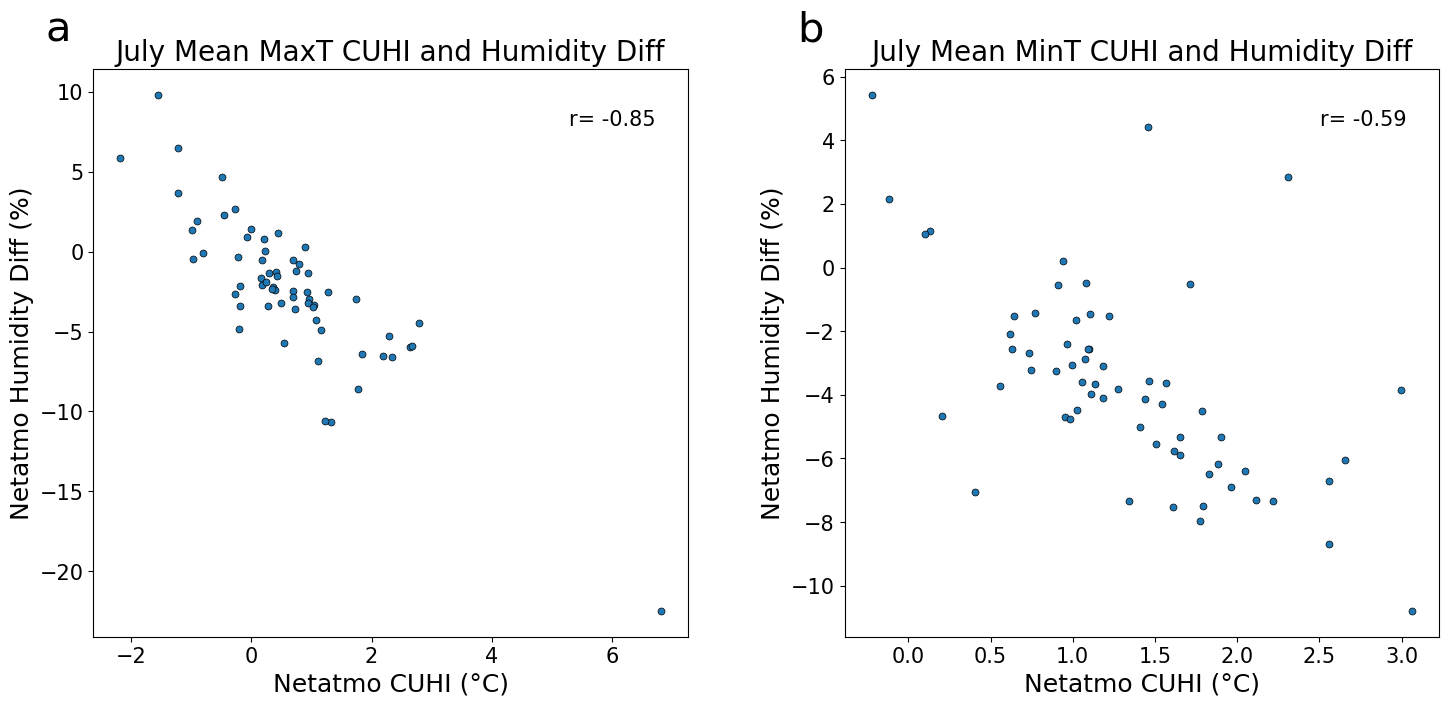

In [32]:
########################
##### CUHI vs UDI ######
########################

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,2, figsize = (16, 8))
fig.tight_layout(pad=7.0)
# Tmax
cuhi = netatmo_CUHI_Tmax_df.CUHI_Tmax
udi = netatmo_CUHI_Tmax_df.Humidity_Diff_Tmax

axes[0].scatter( cuhi, udi, s = 25, edgecolors='k', linewidths=0.5)
axes[0].set(title = 'July Mean MaxT CUHI and Humidity Diff', 
         xlabel = 'Netatmo CUHI (\u00b0C)', ylabel = 'Netatmo Humidity Diff (%)')

#text labels
axes[0].text(0.8, 0.9, 'r= {}'.format(round(pearsonr(cuhi, udi)[0], 2)), fontsize=15, transform=axes[0].transAxes)

# Tmin
cuhi = netatmo_CUHI_Tmin_df.CUHI_Tmin
udi = netatmo_CUHI_Tmin_df.Humidity_Diff_Tmin

axes[1].scatter( cuhi, udi, s = 25, edgecolors='k', linewidths=0.5)
axes[1].set(title = 'July Mean MinT CUHI and Humidity Diff', 
         xlabel = 'Netatmo CUHI (\u00b0C)', ylabel = 'Netatmo Humidity Diff (%)')

#text labels
axes[1].text(0.8, 0.9, 'r= {}'.format(round(pearsonr(cuhi, udi)[0], 2)), fontsize=15, transform=axes[1].transAxes)


#add letters for figs
axes[0].text(-0.08, 1.05, 'a', fontsize=30, transform=axes[0].transAxes)
axes[1].text(-0.08, 1.05, 'b', fontsize=30, transform=axes[1].transAxes)

In [33]:
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'DDL', 'Netatmo','Data'))
buffer_CUHI_cities_july2019 = pd.read_csv('buffer_CUHI_cities_july2019.csv')

GDAT_CUHIs = buffer_CUHI_cities_july2019[['uesi_id','July_buffer_CUHIMAX','July_buffer_CUHIMIN','July_buffer_rural_T_Max_mean',
                            'July_buffer_rural_T_Min_mean','July_buffer_urban_T_Max_mean','July_buffer_urban_T_Min_mean']].groupby(
                            ['uesi_id']).mean().reset_index()

In [34]:
# merge the netatmo and GDAT
Tmax_netatmo_GDAT_buffer_CUHI = netatmo_CUHI_Tmax_df.merge(GDAT_CUHIs[['uesi_id','July_buffer_CUHIMAX','July_buffer_rural_T_Max_mean',
                                'July_buffer_urban_T_Max_mean']]  , on = 'uesi_id', how = 'left')

Tmin_netatmo_GDAT_buffer_CUHI = netatmo_CUHI_Tmin_df.merge(GDAT_CUHIs[['uesi_id','July_buffer_CUHIMIN','July_buffer_rural_T_Min_mean',
                                'July_buffer_urban_T_Min_mean']]  , on = 'uesi_id', how = 'left')

#remove GDAT nan (101 Reykjavik)
Tmax_netatmo_GDAT_buffer_CUHI = Tmax_netatmo_GDAT_buffer_CUHI[~np.isnan(Tmax_netatmo_GDAT_buffer_CUHI.July_buffer_CUHIMAX)].reset_index() 
Tmin_netatmo_GDAT_buffer_CUHI = Tmin_netatmo_GDAT_buffer_CUHI[~np.isnan(Tmin_netatmo_GDAT_buffer_CUHI.July_buffer_CUHIMIN)].reset_index() 

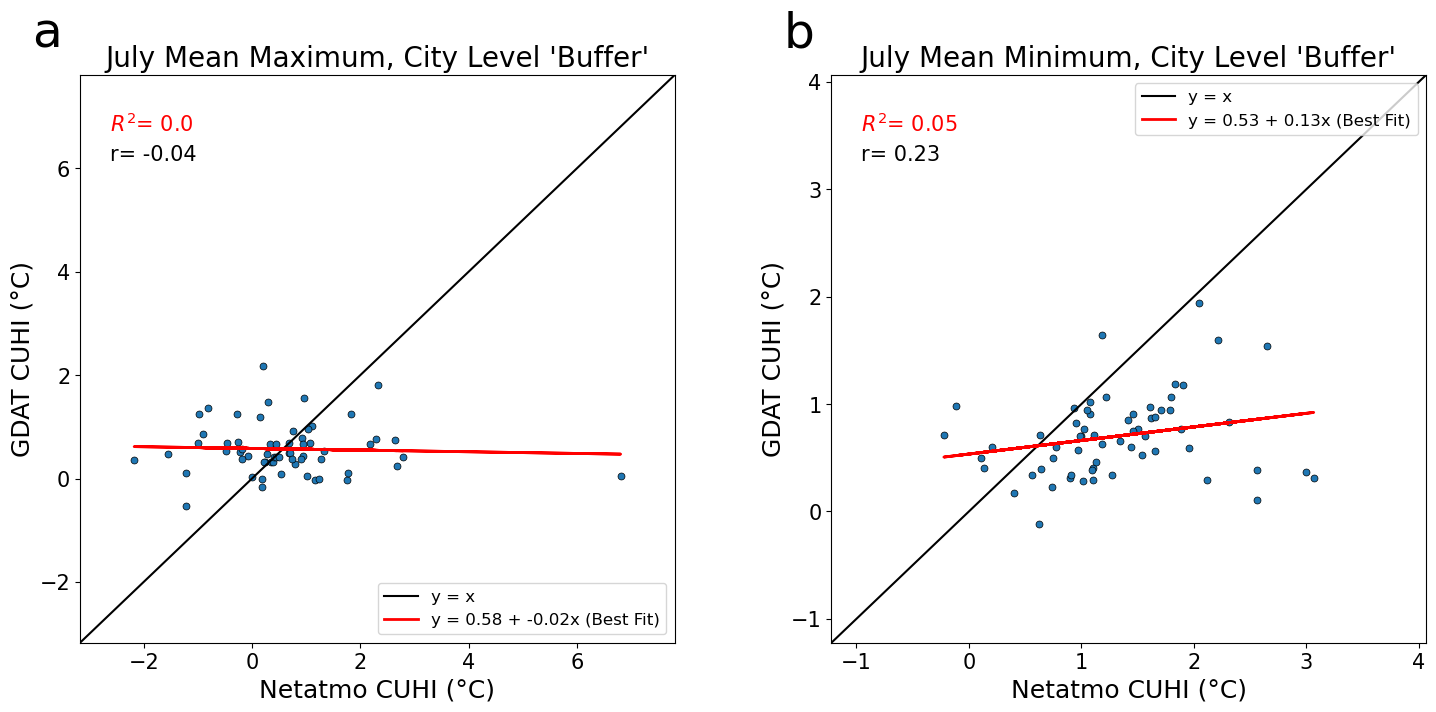

In [35]:
###### Plots showing comparison of netatmo vs GDAT CUHIs #######

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,2, figsize = (16, 8))
fig.tight_layout(pad=7.0)
# Tmax
netatmo_temp = Tmax_netatmo_GDAT_buffer_CUHI.CUHI_Tmax
GDAT_temp = Tmax_netatmo_GDAT_buffer_CUHI.July_buffer_CUHIMAX

axes[0].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
axes[0].set(title = "July Mean Maximum, City Level 'Buffer'", 
         xlabel = 'Netatmo CUHI (\u00b0C)', ylabel = 'GDAT CUHI (\u00b0C)')

axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

axes[0].set_xlim([axesmin, axesmax])
axes[0].set_ylim([axesmin, axesmax])
# x = y line
axes[0].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

#get the intercept/ slope of best fit line and prediction interval
sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
b = sm_model.params.iloc[0]
a = sm_model.params.iloc[1]
sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

axes[0].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

#text labels
axes[0].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=15,color ='red', transform=axes[0].transAxes)
axes[0].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=15, transform=axes[0].transAxes)

axes[0].legend(loc = 4)

# Tmin
netatmo_temp = Tmin_netatmo_GDAT_buffer_CUHI.CUHI_Tmin
GDAT_temp = Tmin_netatmo_GDAT_buffer_CUHI.July_buffer_CUHIMIN

axes[1].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
axes[1].set(title ="July Mean Minimum, City Level 'Buffer'", 
         xlabel = 'Netatmo CUHI (\u00b0C)', ylabel = 'GDAT CUHI (\u00b0C)')

axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

axes[1].set_xlim([axesmin, axesmax])
axes[1].set_ylim([axesmin, axesmax])
# x = y line
axes[1].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

#get the intercept/ slope of best fit line and prediction interval
sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
b = sm_model.params.iloc[0]
a = sm_model.params.iloc[1]
sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

axes[1].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

#text labels
axes[1].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=15,color ='red', transform=axes[1].transAxes)
axes[1].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=15, transform=axes[1].transAxes)

axes[1].legend(loc = 1)

#add letters for figs
axes[0].text(-0.08, 1.05, 'a', fontsize=35, transform=axes[0].transAxes)
axes[1].text(-0.08, 1.05, 'b', fontsize=35, transform=axes[1].transAxes)

#save the plot
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','DDL' ,'Netatmo')) 
plt.savefig('Buffer_method_netatmo_vs_GDAT_CUHI_scatter.png', bbox_inches="tight",dpi=800)
    # dpi increased to give better quality image, but does take longer to save

In [36]:
###################################################################################
### Calculating the CUHI based on the urban - rural within city area difference ###
###################################################################################

## City Level ##
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'DDL', 'Netatmo','Data'))
City_Level_CUHI_cities_GDAT = pd.read_csv('City_Level_CUHI_cities_july2019.csv')

# Add in geometries for polygon shapes in the CUHI cities ee table 
#shapefiles = pd.DataFrame()
#for i in City_Level_CUHI_cities_GDAT['.geo'].values:
#    shapefile = gpd.read_file(i)
#    shapefiles = pd.concat([shapefiles, shapefile])

#City_Level_CUHI_cities_GDAT['geometry'] = shapefiles.geometry.values

# create geopandas df
#City_Level_CUHI_cities_GDAT_gdf = gpd.GeoDataFrame(City_Level_CUHI_cities_GDAT)

#join the GDAT data onto the netatmo
#Tmax_gdf = gpd.sjoin(netatmo_Tmax_pointsWithLandcover_gdf,CUHI_cities_july2019_gdf,how="inner", predicate='intersects')
#Tmin_gdf = gpd.sjoin(netatmo_Tmin_pointsWithLandcover_gdf,CUHI_cities_july2019_gdf,how="inner", predicate='intersects')

In [37]:
# add the city level UESI ID into the netatmo datapoints

########### TMAX ###########################################################################################################
city_level_Tmax = gpd.sjoin(netatmo_Tmax_pointsWithLandcover_gdf,urban_diss_gdf,how="left", predicate='intersects')
# remove rows which do not fall within the UESI urban areas
city_level_Tmax = city_level_Tmax[~pd.isnull(city_level_Tmax.uesi_id)].reset_index()
# create urban flag column
city_level_Tmax['is_urban_flag'] = 0
city_level_Tmax.loc[city_level_Tmax.landcover_type == '50','is_urban_flag'] =1

city_level_Tmax_CUHI = city_level_Tmax[['uesi_id','is_urban_flag','Humidity','Temperatur']].groupby(['uesi_id','is_urban_flag']).mean().reset_index()
# add in how many netatmo stations there in the 'urban'/'rural' within city
count_df = city_level_Tmax[['uesi_id','is_urban_flag','Humidity']].groupby(['uesi_id','is_urban_flag']).count().reset_index(
    ).rename(columns = {'Humidity':'Netatmo_Count'})
city_level_Tmax_CUHI = city_level_Tmax_CUHI.merge(count_df, on =['uesi_id','is_urban_flag'] )

# get the rural and urban temperatures separately then merge
rural_df = city_level_Tmax_CUHI[city_level_Tmax_CUHI.is_urban_flag == 0].rename(columns = {'Humidity':'Rural_Humidity',
              'Temperatur':'Rural_Temperature', 'Netatmo_Count':'Rural_Netatmo_Count'})[['uesi_id','Rural_Humidity',
                                                                   'Rural_Temperature', 'Rural_Netatmo_Count']]

urban_df = city_level_Tmax_CUHI[city_level_Tmax_CUHI.is_urban_flag == 1].rename(columns = {'Humidity':'Urban_Humidity',
              'Temperatur':'Urban_Temperature', 'Netatmo_Count':'Urban_Netatmo_Count'})[['uesi_id','Urban_Humidity',
                                                                   'Urban_Temperature', 'Urban_Netatmo_Count']]

city_level_Tmax_CUHI_2 = urban_df.merge(rural_df, on = 'uesi_id', how = 'inner')
city_level_Tmax_CUHI_2['Netatmo_CUHI'] = city_level_Tmax_CUHI_2['Urban_Temperature']-city_level_Tmax_CUHI_2['Rural_Temperature']

# add in the GDAT CUHIs
city_level_Tmax_CUHI_2 = city_level_Tmax_CUHI_2.merge(City_Level_CUHI_cities_GDAT[['uesi_id','July_City_Level_CUHIMAX']]
                                   .groupby(['uesi_id']).mean().reset_index(), 
                                    how = 'inner', on = 'uesi_id')

########### TMIN ###########################################################################################################
city_level_Tmin = gpd.sjoin(netatmo_Tmin_pointsWithLandcover_gdf,urban_diss_gdf,how="left", predicate='intersects')
# remove rows which do not fall within the UESI urban areas
city_level_Tmin = city_level_Tmin[~pd.isnull(city_level_Tmin.uesi_id)].reset_index()
# create urban flag column
city_level_Tmin['is_urban_flag'] = 0
city_level_Tmin.loc[city_level_Tmin.landcover_type == '50','is_urban_flag'] =1

city_level_Tmin_CUHI = city_level_Tmin[['uesi_id','is_urban_flag','Humidity','Temperatur']].groupby(['uesi_id','is_urban_flag']).mean().reset_index()
# add in how many netatmo stations there in the 'urban'/'rural' within city
count_df = city_level_Tmin[['uesi_id','is_urban_flag','Humidity']].groupby(['uesi_id','is_urban_flag']).count().reset_index(
    ).rename(columns = {'Humidity':'Netatmo_Count'})
city_level_Tmin_CUHI = city_level_Tmin_CUHI.merge(count_df, on =['uesi_id','is_urban_flag'] )

# get the rural and urban temperatures separately then merge
rural_df = city_level_Tmin_CUHI[city_level_Tmin_CUHI.is_urban_flag == 0].rename(columns = {'Humidity':'Rural_Humidity',
              'Temperatur':'Rural_Temperature', 'Netatmo_Count':'Rural_Netatmo_Count'})[['uesi_id','Rural_Humidity',
                                                                   'Rural_Temperature', 'Rural_Netatmo_Count']]

urban_df = city_level_Tmin_CUHI[city_level_Tmin_CUHI.is_urban_flag == 1].rename(columns = {'Humidity':'Urban_Humidity',
              'Temperatur':'Urban_Temperature', 'Netatmo_Count':'Urban_Netatmo_Count'})[['uesi_id','Urban_Humidity',
                                                                   'Urban_Temperature', 'Urban_Netatmo_Count']]

city_level_Tmin_CUHI_2 = urban_df.merge(rural_df, on = 'uesi_id', how = 'inner')
city_level_Tmin_CUHI_2['Netatmo_CUHI'] = city_level_Tmin_CUHI_2['Urban_Temperature']-city_level_Tmin_CUHI_2['Rural_Temperature']

# add in the GDAT CUHIs
city_level_Tmin_CUHI_2 = city_level_Tmin_CUHI_2.merge(City_Level_CUHI_cities_GDAT[['uesi_id','July_City_Level_CUHIMIN']]
                                   .groupby(['uesi_id']).mean().reset_index(), 
                                    how = 'inner', on = 'uesi_id')

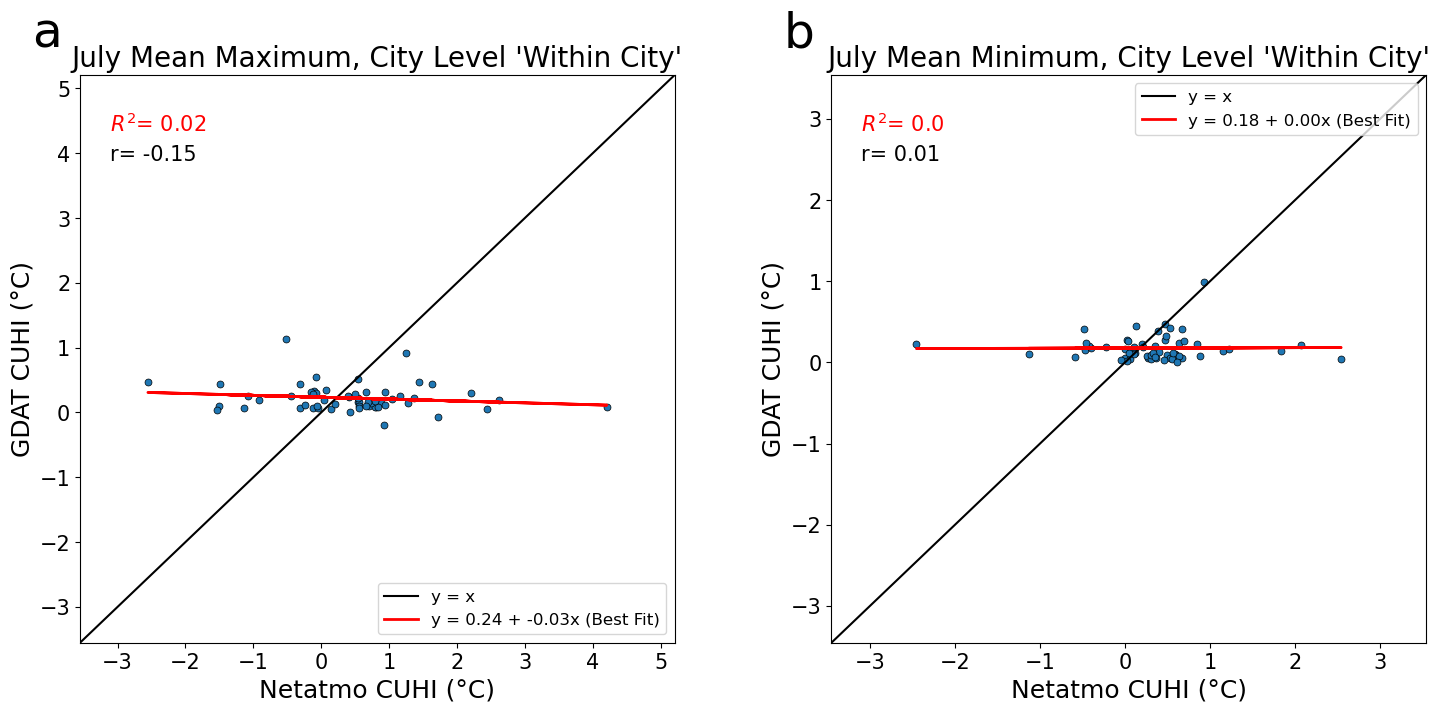

In [38]:
###### Plots showing comparison of netatmo vs GDAT 'within city' CUHIs #######

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,2, figsize = (16, 8))
fig.tight_layout(pad=7.0)
# Tmax
netatmo_temp = city_level_Tmax_CUHI_2.Netatmo_CUHI
GDAT_temp = city_level_Tmax_CUHI_2.July_City_Level_CUHIMAX

axes[0].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
axes[0].set(title = "July Mean Maximum, City Level 'Within City'", 
         xlabel = 'Netatmo CUHI (\u00b0C)', ylabel = 'GDAT CUHI (\u00b0C)')

axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

axes[0].set_xlim([axesmin, axesmax])
axes[0].set_ylim([axesmin, axesmax])
# x = y line
axes[0].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

#get the intercept/ slope of best fit line and prediction interval
sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
b = sm_model.params.iloc[0]
a = sm_model.params.iloc[1]
sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

axes[0].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

#text labels
axes[0].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=15,color ='red', transform=axes[0].transAxes)
axes[0].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=15, transform=axes[0].transAxes)

axes[0].legend(loc = 4)

# Tmin
netatmo_temp = city_level_Tmin_CUHI_2.Netatmo_CUHI
GDAT_temp = city_level_Tmin_CUHI_2.July_City_Level_CUHIMIN

axes[1].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
axes[1].set(title =  "July Mean Minimum, City Level 'Within City'",
         xlabel = 'Netatmo CUHI (\u00b0C)', ylabel = 'GDAT CUHI (\u00b0C)')

axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

axes[1].set_xlim([axesmin, axesmax])
axes[1].set_ylim([axesmin, axesmax])
# x = y line
axes[1].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

#get the intercept/ slope of best fit line and prediction interval
sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
b = sm_model.params.iloc[0]
a = sm_model.params.iloc[1]
sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

axes[1].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

#text labels
axes[1].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=15,color ='red', transform=axes[1].transAxes)
axes[1].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=15, transform=axes[1].transAxes)

axes[1].legend(loc = 1)

#add letters for figs
axes[0].text(-0.08, 1.05, 'a', fontsize=35, transform=axes[0].transAxes)
axes[1].text(-0.08, 1.05, 'b', fontsize=35, transform=axes[1].transAxes)

#save the plot
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','DDL' ,'Netatmo')) 
plt.savefig('within_city_method_netatmo_vs_GDAT_CUHI_scatter.png', bbox_inches="tight",dpi=800)
    # dpi increased to give better quality image, but does take longer to save

In [39]:
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'DDL', 'Netatmo','Data'))
netatmo_vs_GDAT_Tmax = pd.read_csv('netatmo_vs_GDAT_Tmax.csv')
netatmo_vs_GDAT_Tmin = pd.read_csv('netatmo_vs_GDAT_Tmin.csv')

netatmo_vs_GDAT_Tmax_gdf = gpd.GeoDataFrame(netatmo_vs_GDAT_Tmax, 
                                    geometry = gpd.points_from_xy(netatmo_vs_GDAT_Tmax["Lon"], 
                                     netatmo_vs_GDAT_Tmax["Lat"]), crs="epsg:4326")

netatmo_vs_GDAT_Tmin_gdf = gpd.GeoDataFrame(netatmo_vs_GDAT_Tmin, 
                                    geometry = gpd.points_from_xy(netatmo_vs_GDAT_Tmin["Lon"], 
                                     netatmo_vs_GDAT_Tmin["Lat"]), crs="epsg:4326")

# get landcover types out of the list format
temp_list = []
for i in range(len(netatmo_vs_GDAT_Tmax_gdf)):
    preextracted = netatmo_vs_GDAT_Tmax_gdf['tmax'].iloc[i]
    end_index = preextracted.index(']')
    extracted = preextracted[1:end_index]
    if extracted == '':
        extracted = np.nan
    else: extracted = float(extracted)
    temp_list.append(extracted)

netatmo_vs_GDAT_Tmax_gdf['GDAT_Tmax'] = temp_list

temp_list = []
for i in range(len(netatmo_vs_GDAT_Tmin_gdf)):
    preextracted = netatmo_vs_GDAT_Tmin_gdf['tmin'].iloc[i]
    end_index = preextracted.index(']')
    extracted = preextracted[1:end_index]
    if extracted == '':
        extracted = np.nan
    else: extracted = float(extracted)
    temp_list.append(extracted)

netatmo_vs_GDAT_Tmin_gdf['GDAT_Tmin'] = temp_list

In [42]:
# remove nans for plotting
netatmo_vs_GDAT_Tmax_gdf = netatmo_vs_GDAT_Tmax_gdf[~np.isnan(netatmo_vs_GDAT_Tmax_gdf.GDAT_Tmax)].reset_index()
netatmo_vs_GDAT_Tmin_gdf = netatmo_vs_GDAT_Tmin_gdf[~np.isnan(netatmo_vs_GDAT_Tmin_gdf.GDAT_Tmin)].reset_index()

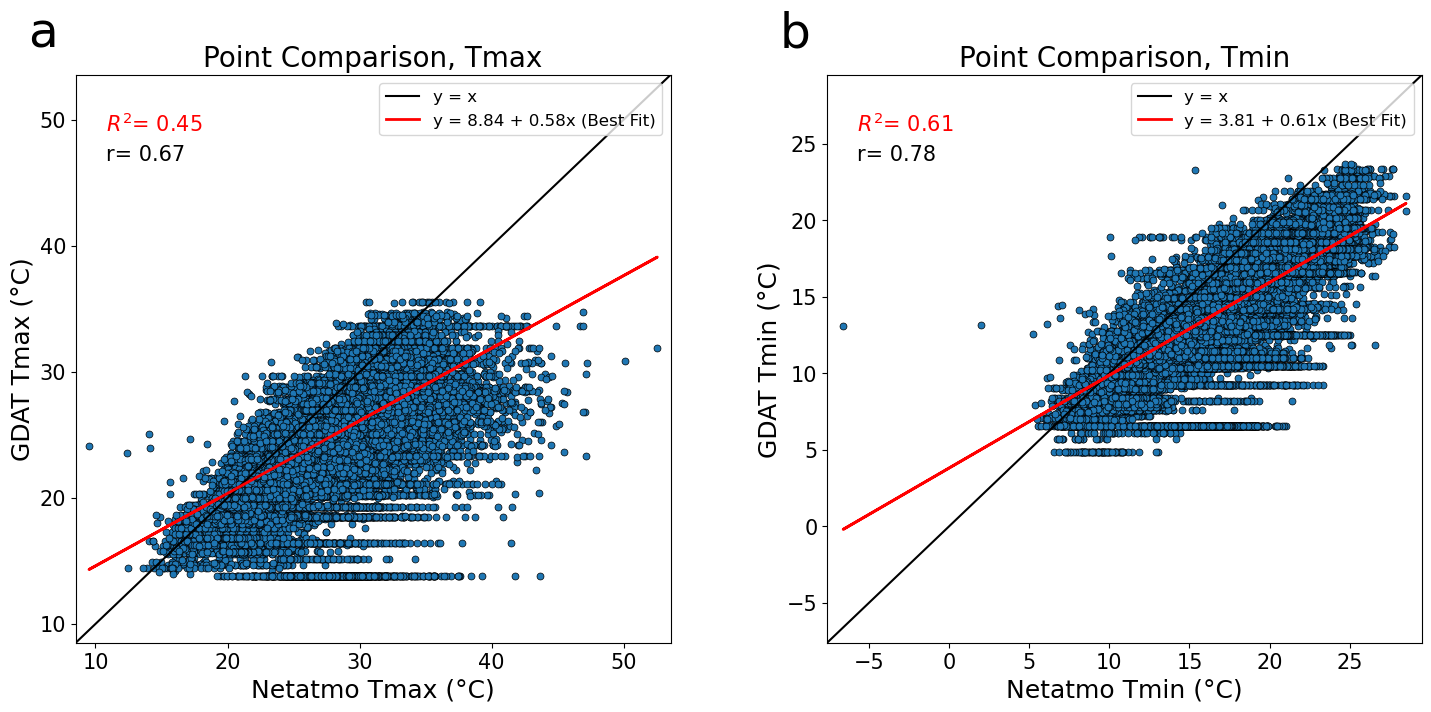

In [43]:
###### Plots showing comparison of netatmo point vs overlying GDAT pixel area #######

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,2, figsize = (16, 8))
fig.tight_layout(pad=7.0)
# Tmax
netatmo_temp = netatmo_vs_GDAT_Tmax_gdf.Temperatur
GDAT_temp = netatmo_vs_GDAT_Tmax_gdf.GDAT_Tmax

axes[0].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
axes[0].set(title = 'Point Comparison, Tmax', 
         xlabel = 'Netatmo Tmax (\u00b0C)', ylabel = 'GDAT Tmax (\u00b0C)')

axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

axes[0].set_xlim([axesmin, axesmax])
axes[0].set_ylim([axesmin, axesmax])
# x = y line
axes[0].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

#get the intercept/ slope of best fit line and prediction interval
sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
b = sm_model.params.iloc[0]
a = sm_model.params.iloc[1]
sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

axes[0].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

#text labels
axes[0].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=15,color ='red', transform=axes[0].transAxes)
axes[0].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=15, transform=axes[0].transAxes)

axes[0].legend(loc = 1)

# Tmin
netatmo_temp = netatmo_vs_GDAT_Tmin_gdf.Temperatur
GDAT_temp = netatmo_vs_GDAT_Tmin_gdf.GDAT_Tmin

axes[1].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
axes[1].set(title = 'Point Comparison, Tmin', 
         xlabel = 'Netatmo Tmin (\u00b0C)', ylabel = 'GDAT Tmin (\u00b0C)')

axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

axes[1].set_xlim([axesmin, axesmax])
axes[1].set_ylim([axesmin, axesmax])
# x = y line
axes[1].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

#get the intercept/ slope of best fit line and prediction interval
sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
b = sm_model.params.iloc[0]
a = sm_model.params.iloc[1]
sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

axes[1].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

#text labels
axes[1].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=15,color ='red', transform=axes[1].transAxes)
axes[1].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=15, transform=axes[1].transAxes)

axes[1].legend(loc = 1)

#add letters for figs
axes[0].text(-0.08, 1.05, 'a', fontsize=35, transform=axes[0].transAxes)
axes[1].text(-0.08, 1.05, 'b', fontsize=35, transform=axes[1].transAxes)

#save the plot
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','DDL' ,'Netatmo')) 
plt.savefig('point_comp_netatmo_vs_GDAT_scatter.png', bbox_inches="tight",dpi=800)
    # dpi increased to give better quality image, but does take longer to save

In [53]:
# add in GDAT point to point temps
netatmo_Tmax_pointsWithLandcover_gdf = netatmo_Tmax_pointsWithLandcover_gdf.merge(netatmo_vs_GDAT_Tmax_gdf[['ID','Lat','Lon','GDAT_Tmax']], 
                                           on = ['ID','Lat','Lon'], how = 'left')

netatmo_Tmin_pointsWithLandcover_gdf = netatmo_Tmin_pointsWithLandcover_gdf.merge(netatmo_vs_GDAT_Tmin_gdf[['ID','Lat','Lon','GDAT_Tmin']], 
                                           on = ['ID','Lat','Lon'], how = 'left')

In [54]:
############### Point Equivalent CUHIs ###########################

# add in GDAT point to point temps
netatmo_Tmax_pointsWithLandcover_gdf = netatmo_Tmax_pointsWithLandcover_gdf.merge(netatmo_vs_GDAT_Tmax_gdf[['ID','Lat','Lon','GDAT_Tmax']], 
                                           on = ['ID','Lat','Lon'], how = 'left')

netatmo_Tmin_pointsWithLandcover_gdf = netatmo_Tmin_pointsWithLandcover_gdf.merge(netatmo_vs_GDAT_Tmin_gdf[['ID','Lat','Lon','GDAT_Tmin']], 
                                           on = ['ID','Lat','Lon'], how = 'left')

### 'within city' method ###

## T MAX ##
direct_comp_Tmax = gpd.sjoin(netatmo_Tmax_pointsWithLandcover_gdf,urban_diss_gdf,how="left", predicate='intersects')
direct_comp_Tmax['GDAT_Tmax'] = pd.to_numeric(direct_comp_Tmax.GDAT_Tmax)
# remove rows which do not fall within the UESI urban areas
direct_comp_Tmax = direct_comp_Tmax[~pd.isnull(direct_comp_Tmax.uesi_id)].reset_index()
# create urban flag column
direct_comp_Tmax['is_urban_flag'] = 0
direct_comp_Tmax.loc[direct_comp_Tmax.landcover_type == '50','is_urban_flag'] =1

direct_comp_Tmax_CUHI = direct_comp_Tmax[['uesi_id','is_urban_flag','Humidity','Temperatur','GDAT_Tmax']].groupby(['uesi_id','is_urban_flag']).mean(
                                                                                                                                ).reset_index()
# add in how many netatmo stations there in the 'urban'/'rural' within city
count_df = direct_comp_Tmax[['uesi_id','is_urban_flag','Humidity']].groupby(['uesi_id','is_urban_flag']).count().reset_index(
    ).rename(columns = {'Humidity':'Netatmo_Count'})
direct_comp_Tmax_CUHI = direct_comp_Tmax_CUHI.merge(count_df, on =['uesi_id','is_urban_flag'] )

# get the rural and urban temperatures separately then merge
rural_df = direct_comp_Tmax_CUHI[direct_comp_Tmax_CUHI.is_urban_flag == 0].rename(columns = {'Humidity':'Rural_Humidity',
              'Temperatur':'Rural_Temperature', 'Netatmo_Count':'Rural_Netatmo_Count','GDAT_Tmax':'Rural_GDAT_Tmax'})[['uesi_id','Rural_Humidity',
                                                                   'Rural_Temperature', 'Rural_Netatmo_Count','Rural_GDAT_Tmax']]

urban_df = direct_comp_Tmax_CUHI[direct_comp_Tmax_CUHI.is_urban_flag == 1].rename(columns = {'Humidity':'Urban_Humidity',
              'Temperatur':'Urban_Temperature', 'Netatmo_Count':'Urban_Netatmo_Count','GDAT_Tmax':'Urban_GDAT_Tmax'})[['uesi_id','Urban_Humidity',
                                                                   'Urban_Temperature', 'Urban_Netatmo_Count','Urban_GDAT_Tmax']]

direct_comp_Tmax_CUHI_2 = urban_df.merge(rural_df, on = 'uesi_id', how = 'inner')
direct_comp_Tmax_CUHI_2['Netatmo_CUHI'] = direct_comp_Tmax_CUHI_2['Urban_Temperature']-direct_comp_Tmax_CUHI_2['Rural_Temperature']
direct_comp_Tmax_CUHI_2['GDAT_CUHI'] = direct_comp_Tmax_CUHI_2['Urban_GDAT_Tmax']-direct_comp_Tmax_CUHI_2['Rural_GDAT_Tmax']

## T MIN ##

direct_comp_Tmin = gpd.sjoin(netatmo_Tmin_pointsWithLandcover_gdf,urban_diss_gdf,how="left", predicate='intersects')
direct_comp_Tmin['GDAT_Tmin'] = pd.to_numeric(direct_comp_Tmin.GDAT_Tmin)
# remove rows which do not fall within the UESI urban areas
direct_comp_Tmin = direct_comp_Tmin[~pd.isnull(direct_comp_Tmin.uesi_id)].reset_index()
# create urban flag column
direct_comp_Tmin['is_urban_flag'] = 0
direct_comp_Tmin.loc[direct_comp_Tmin.landcover_type == '50','is_urban_flag'] =1

direct_comp_Tmin_CUHI = direct_comp_Tmin[['uesi_id','is_urban_flag','Humidity','Temperatur','GDAT_Tmin']].groupby(['uesi_id','is_urban_flag']).mean(
                                                                                                                                ).reset_index()
# add in how many netatmo stations there in the 'urban'/'rural' within city
count_df = direct_comp_Tmin[['uesi_id','is_urban_flag','Humidity']].groupby(['uesi_id','is_urban_flag']).count().reset_index(
    ).rename(columns = {'Humidity':'Netatmo_Count'})
direct_comp_Tmin_CUHI = direct_comp_Tmin_CUHI.merge(count_df, on =['uesi_id','is_urban_flag'] )

# get the rural and urban temperatures separately then merge
rural_df = direct_comp_Tmin_CUHI[direct_comp_Tmin_CUHI.is_urban_flag == 0].rename(columns = {'Humidity':'Rural_Humidity',
              'Temperatur':'Rural_Temperature', 'Netatmo_Count':'Rural_Netatmo_Count','GDAT_Tmin':'Rural_GDAT_Tmin'})[['uesi_id','Rural_Humidity',
                                                                   'Rural_Temperature', 'Rural_Netatmo_Count','Rural_GDAT_Tmin']]

urban_df = direct_comp_Tmin_CUHI[direct_comp_Tmin_CUHI.is_urban_flag == 1].rename(columns = {'Humidity':'Urban_Humidity',
              'Temperatur':'Urban_Temperature', 'Netatmo_Count':'Urban_Netatmo_Count','GDAT_Tmin':'Urban_GDAT_Tmin'})[['uesi_id','Urban_Humidity',
                                                                   'Urban_Temperature', 'Urban_Netatmo_Count','Urban_GDAT_Tmin']]

direct_comp_Tmin_CUHI_2 = urban_df.merge(rural_df, on = 'uesi_id', how = 'inner')
direct_comp_Tmin_CUHI_2['Netatmo_CUHI'] = direct_comp_Tmin_CUHI_2['Urban_Temperature']-direct_comp_Tmin_CUHI_2['Rural_Temperature']
direct_comp_Tmin_CUHI_2['GDAT_CUHI'] = direct_comp_Tmin_CUHI_2['Urban_GDAT_Tmin']-direct_comp_Tmin_CUHI_2['Rural_GDAT_Tmin']

# get rid of nans
direct_comp_Tmax_CUHI_2 = direct_comp_Tmax_CUHI_2[~np.isnan(direct_comp_Tmax_CUHI_2.Rural_GDAT_Tmax)].reset_index()
direct_comp_Tmin_CUHI_2 = direct_comp_Tmin_CUHI_2[~np.isnan(direct_comp_Tmin_CUHI_2.Rural_GDAT_Tmin)].reset_index()

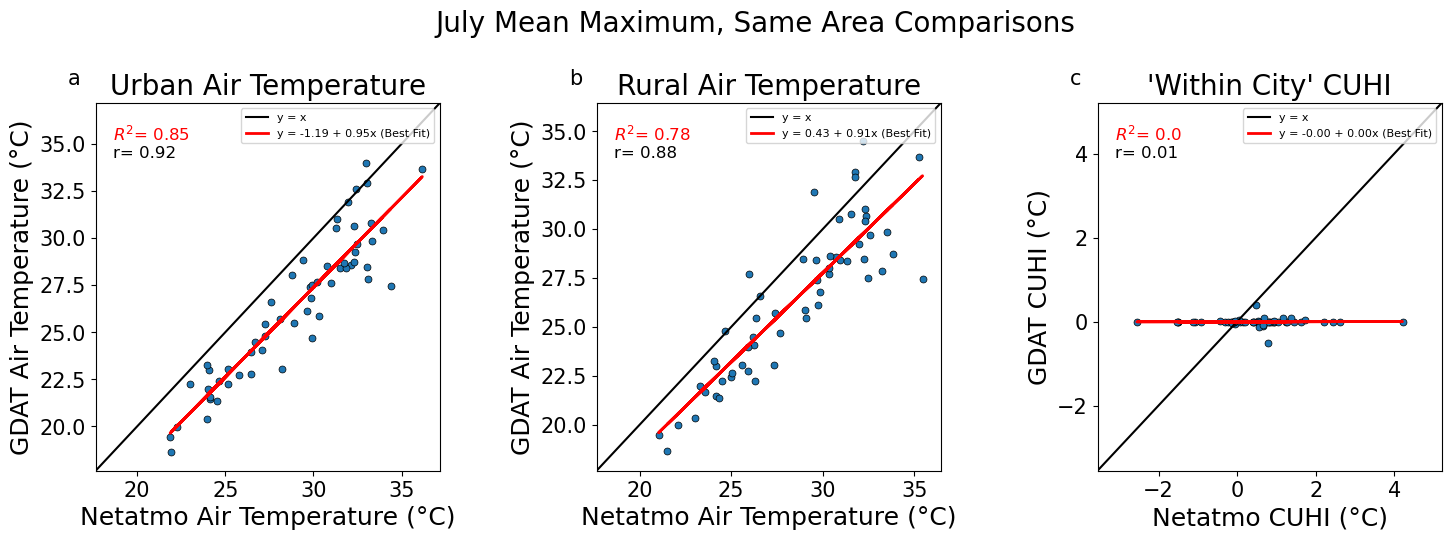

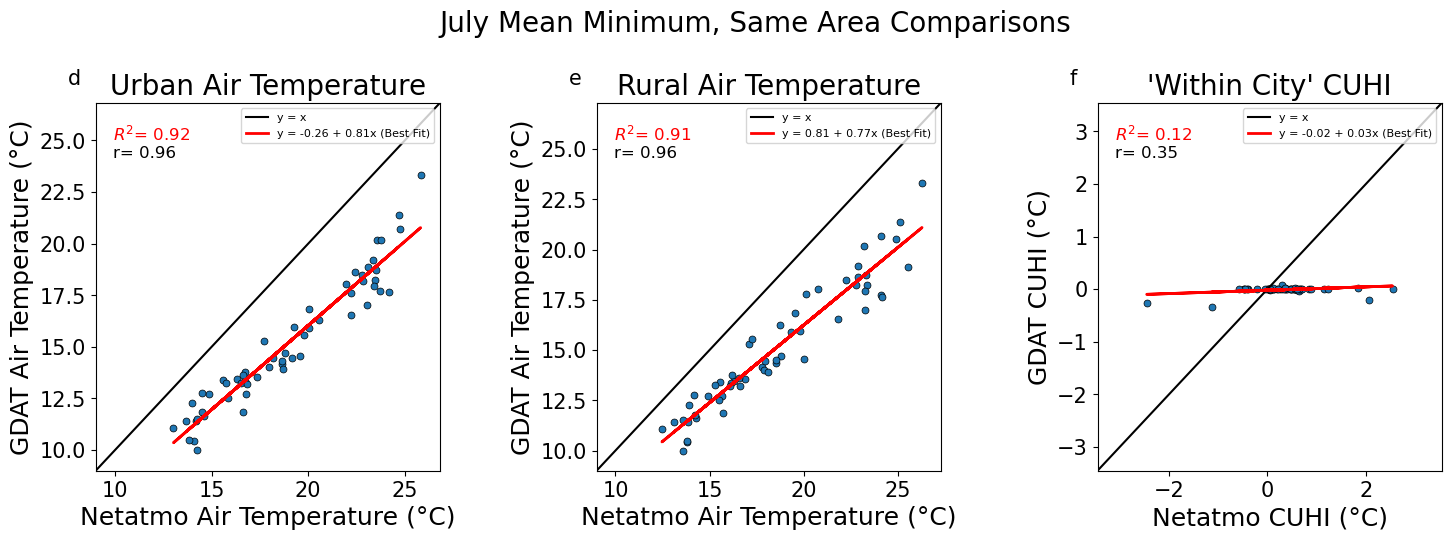

In [56]:
# Looking at correlations between the netatmo data and the GDAT data
# 1. Urban Temp
# 2. Rural Temp
# 3. CUHI - Urban Temp - Rural Temp 

######################
##### MAX TEMP #######
######################

# Plot

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,3, figsize = (16, 6))
fig.tight_layout(pad=7.0)
fig.suptitle('July Mean Maximum, Same Area Comparisons')
# Tmax
row_num = 0
labels = ['a','b','c']
netatmo_fields = ['Urban_Temperature', 'Rural_Temperature','Netatmo_CUHI']
GDAT_fields = ['Urban_GDAT_Tmax','Rural_GDAT_Tmax','GDAT_CUHI']
xlabels = ['Netatmo Air Temperature (\u00b0C)', 'Netatmo Air Temperature (\u00b0C)','Netatmo CUHI (\u00b0C)']
ylabels = ['GDAT Air Temperature (\u00b0C)','GDAT Air Temperature (\u00b0C)','GDAT CUHI (\u00b0C)']
titles = ['Urban Air Temperature', 'Rural Air Temperature', "'Within City' CUHI"]

for i in range(3):
    netatmo_temp = direct_comp_Tmax_CUHI_2[netatmo_fields[i]]
    GDAT_temp = direct_comp_Tmax_CUHI_2[GDAT_fields[i]]

    axes[row_num].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
    axes[row_num].set(title = titles[i], 
        xlabel = xlabels[i], ylabel = ylabels[i])

    axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
    axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

    axes[row_num].set_xlim([axesmin, axesmax])
    axes[row_num].set_ylim([axesmin, axesmax])
    # x = y line
    axes[row_num].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

    #get the intercept/ slope of best fit line and prediction interval
    sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
    b = sm_model.params.iloc[0]
    a = sm_model.params.iloc[1]
    sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

    axes[row_num].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

    #text labels
    axes[row_num].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=12,color ='red', 
                         transform=axes[row_num].transAxes)
    axes[row_num].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=12, 
                         transform=axes[row_num].transAxes)

    axes[row_num].legend(loc = 1)
    axes[row_num].text(-0.08, 1.05, labels[row_num], fontsize=15, transform=axes[row_num].transAxes)
    row_num = row_num +1
    
#save the plot
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','DDL' ,'Netatmo')) 
plt.savefig('direct_comp_Tmax_netatmo_vs_GDAT_scatter.png', bbox_inches="tight",dpi=800)
    # dpi increased to give better quality image, but does take longer to save

######################
##### MIN TEMP #######
######################

# Plot

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,3, figsize = (16, 6))
fig.tight_layout(pad=7.0)
fig.suptitle('July Mean Minimum, Same Area Comparisons')
# Tmax
row_num = 0
labels = ['d','e','f']
netatmo_fields = ['Urban_Temperature', 'Rural_Temperature','Netatmo_CUHI']
GDAT_fields = ['Urban_GDAT_Tmin','Rural_GDAT_Tmin','GDAT_CUHI']
xlabels = ['Netatmo Air Temperature (\u00b0C)', 'Netatmo Air Temperature (\u00b0C)','Netatmo CUHI (\u00b0C)']
ylabels = ['GDAT Air Temperature (\u00b0C)','GDAT Air Temperature (\u00b0C)','GDAT CUHI (\u00b0C)']
titles = ['Urban Air Temperature', 'Rural Air Temperature', "'Within City' CUHI"]

for i in range(3):
    netatmo_temp = direct_comp_Tmin_CUHI_2[netatmo_fields[i]]
    GDAT_temp = direct_comp_Tmin_CUHI_2[GDAT_fields[i]]

    axes[row_num].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
    axes[row_num].set(title = titles[i], 
        xlabel = xlabels[i], ylabel = ylabels[i])

    axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
    axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

    axes[row_num].set_xlim([axesmin, axesmax])
    axes[row_num].set_ylim([axesmin, axesmax])
    # x = y line
    axes[row_num].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

    #get the intercept/ slope of best fit line and prediction interval
    sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
    b = sm_model.params.iloc[0]
    a = sm_model.params.iloc[1]
    sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

    axes[row_num].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

    #text labels
    axes[row_num].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=12,color ='red', 
                         transform=axes[row_num].transAxes)
    axes[row_num].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=12, 
                         transform=axes[row_num].transAxes)

    axes[row_num].legend(loc = 1)
    axes[row_num].text(-0.08, 1.05, labels[row_num], fontsize=15, transform=axes[row_num].transAxes)
    row_num = row_num +1
    
#save the plot
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','DDL' ,'Netatmo')) 
plt.savefig('direct_comp_Tmin_netatmo_vs_GDAT_scatter.png', bbox_inches="tight",dpi=800)
    # dpi increased to give better quality image, but does take longer to save

In [59]:
# add in GDAT point to point temps
urban_diss_Tmax_gdf = urban_diss_Tmax_gdf.merge(netatmo_vs_GDAT_Tmax_gdf[['ID','Lat','Lon','GDAT_Tmax']], 
                                           on = ['ID','Lat','Lon'], how = 'left')

rural_buffers_Tmax_gdf = rural_buffers_Tmax_gdf.merge(netatmo_vs_GDAT_Tmax_gdf[['ID','Lat','Lon','GDAT_Tmax']], 
                                           on = ['ID','Lat','Lon'], how = 'left')


urban_diss_Tmin_gdf = urban_diss_Tmin_gdf.merge(netatmo_vs_GDAT_Tmin_gdf[['ID','Lat','Lon','GDAT_Tmin']], 
                                           on = ['ID','Lat','Lon'], how = 'left')

rural_buffers_Tmin_gdf = rural_buffers_Tmin_gdf.merge(netatmo_vs_GDAT_Tmin_gdf[['ID','Lat','Lon','GDAT_Tmin']], 
                                           on = ['ID','Lat','Lon'], how = 'left')


In [60]:
# get netatmo CUHI for Tmax
# at the city level so the temperature and humidity are grouped at the city level
# the points for GDAT taken as the same as where there are netatmo stations
# convert the GDAT column to numeric for calculations
urban_diss_Tmax_gdf['GDAT_Tmax'] = pd.to_numeric(urban_diss_Tmax_gdf['GDAT_Tmax'])
rural_buffers_Tmax_gdf['GDAT_Tmax'] = pd.to_numeric(rural_buffers_Tmax_gdf['GDAT_Tmax'])

rural_df = rural_buffers_Tmax_gdf[['uesi_id','Temperatur','Humidity','GDAT_Tmax']].groupby(
                                'uesi_id').mean().reset_index()

rural_df = rural_df.rename(columns = {'Temperatur': 'Rural_Tmax', 'Humidity': 'Rural_Humidity_atTmax','GDAT_Tmax':'Rural_GDAT_Tmax'})

urban_df = urban_diss_Tmax_gdf[['uesi_id','Temperatur','Humidity','GDAT_Tmax']].groupby(
                                'uesi_id').mean().reset_index()

urban_df = urban_df.rename(columns = {'Temperatur': 'Urban_Tmax', 'Humidity': 'Urban_Humidity_atTmax','GDAT_Tmax':'Urban_GDAT_Tmax'})

netatmo_CUHI_Tmax_df = urban_df.merge(rural_df, how = 'inner', on = ['uesi_id'])
netatmo_CUHI_Tmax_df['CUHI_Tmax'] = netatmo_CUHI_Tmax_df.Urban_Tmax - netatmo_CUHI_Tmax_df.Rural_Tmax
netatmo_CUHI_Tmax_df['Humidity_Diff_Tmax'] = netatmo_CUHI_Tmax_df.Urban_Humidity_atTmax - netatmo_CUHI_Tmax_df.Rural_Humidity_atTmax
netatmo_CUHI_Tmax_df['CUHI_GDAT_Tmax'] = netatmo_CUHI_Tmax_df.Urban_GDAT_Tmax - netatmo_CUHI_Tmax_df.Rural_GDAT_Tmax

# get netatmo CUHI for Tmin
# at the city level so the temperature and humidity are grouped at the city level
# the points for GDAT taken as the same as where there are netatmo stations
# convert the GDAT column to numeric for calculations
urban_diss_Tmin_gdf['GDAT_Tmin'] = pd.to_numeric(urban_diss_Tmin_gdf['GDAT_Tmin'])
rural_buffers_Tmin_gdf['GDAT_Tmin'] = pd.to_numeric(rural_buffers_Tmin_gdf['GDAT_Tmin'])

rural_df = rural_buffers_Tmin_gdf[['uesi_id','Temperatur','Humidity','GDAT_Tmin']].groupby(
                                'uesi_id').mean().reset_index()

rural_df = rural_df.rename(columns = {'Temperatur': 'Rural_Tmin', 'Humidity': 'Rural_Humidity_atTmin','GDAT_Tmin':'Rural_GDAT_Tmin'})

urban_df = urban_diss_Tmin_gdf[['uesi_id','Temperatur','Humidity','GDAT_Tmin']].groupby(
                                'uesi_id').mean().reset_index()

urban_df = urban_df.rename(columns = {'Temperatur': 'Urban_Tmin', 'Humidity': 'Urban_Humidity_atTmin','GDAT_Tmin':'Urban_GDAT_Tmin'})

netatmo_CUHI_Tmin_df = urban_df.merge(rural_df, how = 'inner', on = ['uesi_id'])
netatmo_CUHI_Tmin_df['CUHI_Tmin'] = netatmo_CUHI_Tmin_df.Urban_Tmin - netatmo_CUHI_Tmin_df.Rural_Tmin
netatmo_CUHI_Tmin_df['Humidity_Diff_Tmin'] = netatmo_CUHI_Tmin_df.Urban_Humidity_atTmin - netatmo_CUHI_Tmin_df.Rural_Humidity_atTmin
netatmo_CUHI_Tmin_df['CUHI_GDAT_Tmin'] = netatmo_CUHI_Tmin_df.Urban_GDAT_Tmin - netatmo_CUHI_Tmin_df.Rural_GDAT_Tmin


In [61]:
# remove the nans for plotting
netatmo_CUHI_Tmax_df = netatmo_CUHI_Tmax_df[~np.isnan(netatmo_CUHI_Tmax_df.CUHI_GDAT_Tmax)].reset_index()
netatmo_CUHI_Tmin_df = netatmo_CUHI_Tmin_df[~np.isnan(netatmo_CUHI_Tmin_df.CUHI_GDAT_Tmin)].reset_index()

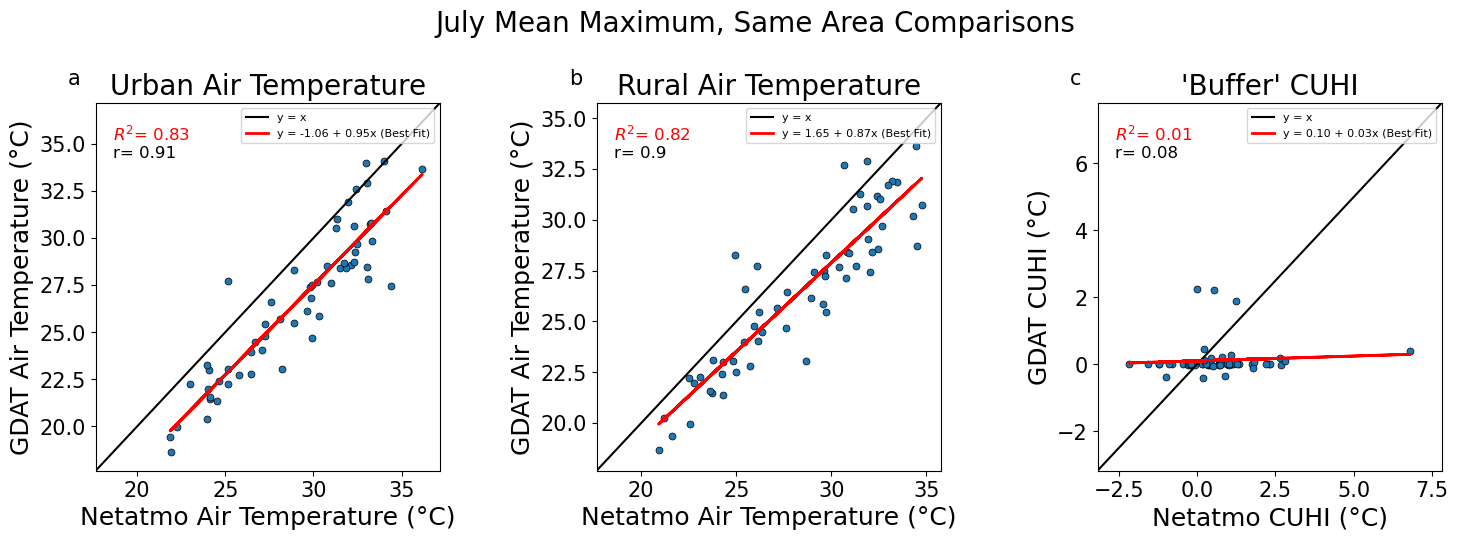

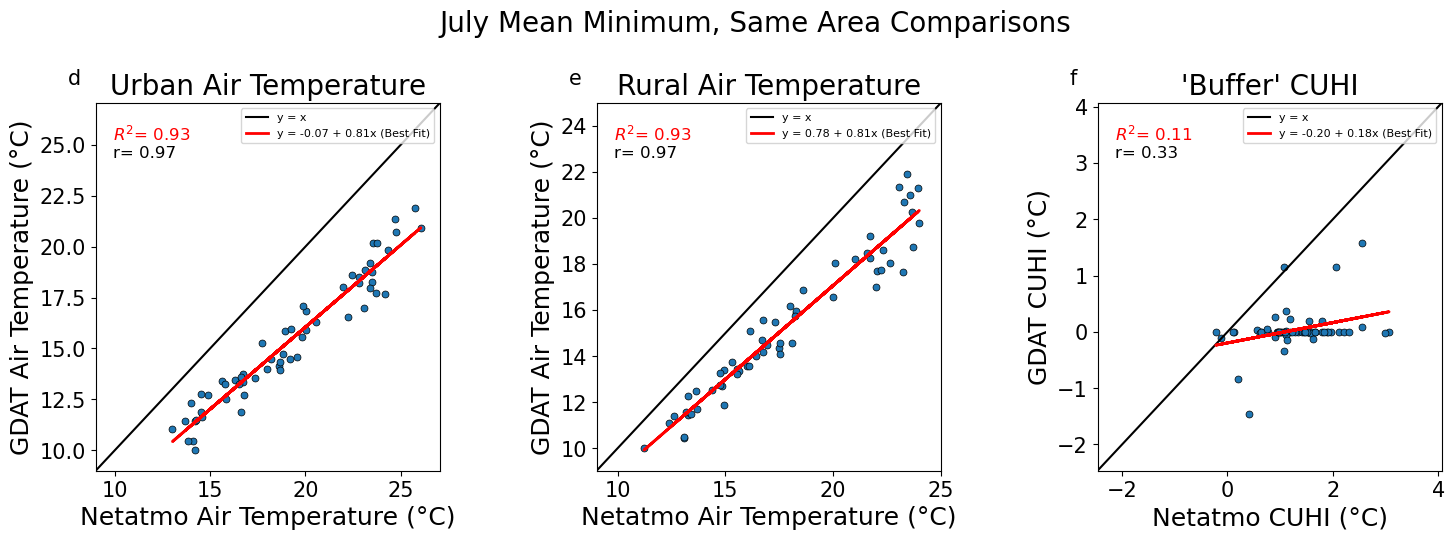

In [62]:
# Looking at correlations between the netatmo data and the GDAT data
# 1. Urban Temp
# 2. Rural Temp
# 3. CUHI - Urban Temp - Rural Temp 

######################
##### MAX TEMP #######
######################

# Plot

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,3, figsize = (16, 6))
fig.tight_layout(pad=7.0)
fig.suptitle('July Mean Maximum, Same Area Comparisons')
# Tmax
row_num = 0
labels = ['a','b','c']
netatmo_fields = ['Urban_Tmax', 'Rural_Tmax','CUHI_Tmax']
GDAT_fields = ['Urban_GDAT_Tmax','Rural_GDAT_Tmax','CUHI_GDAT_Tmax']
xlabels = ['Netatmo Air Temperature (\u00b0C)', 'Netatmo Air Temperature (\u00b0C)','Netatmo CUHI (\u00b0C)']
ylabels = ['GDAT Air Temperature (\u00b0C)','GDAT Air Temperature (\u00b0C)','GDAT CUHI (\u00b0C)']
titles = ['Urban Air Temperature', 'Rural Air Temperature', "'Buffer' CUHI"]

for i in range(3):
    netatmo_temp = netatmo_CUHI_Tmax_df[netatmo_fields[i]]
    GDAT_temp = netatmo_CUHI_Tmax_df[GDAT_fields[i]]

    axes[row_num].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
    axes[row_num].set(title = titles[i], 
        xlabel = xlabels[i], ylabel = ylabels[i])

    axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
    axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

    axes[row_num].set_xlim([axesmin, axesmax])
    axes[row_num].set_ylim([axesmin, axesmax])
    # x = y line
    axes[row_num].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

    #get the intercept/ slope of best fit line and prediction interval
    sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
    b = sm_model.params.iloc[0]
    a = sm_model.params.iloc[1]
    sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

    axes[row_num].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

    #text labels
    axes[row_num].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=12,color ='red', 
                         transform=axes[row_num].transAxes)
    axes[row_num].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=12, 
                         transform=axes[row_num].transAxes)

    axes[row_num].legend(loc = 1)
    axes[row_num].text(-0.08, 1.05, labels[row_num], fontsize=15, transform=axes[row_num].transAxes)
    row_num = row_num +1
    
#save the plot
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','DDL' ,'Netatmo')) 
plt.savefig('buffer_method_direct_comp_Tmax_netatmo_vs_GDAT_scatter.png', bbox_inches="tight",dpi=800)
    # dpi increased to give better quality image, but does take longer to save

######################
##### MIN TEMP #######
######################

# Plot

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,3, figsize = (16, 6))
fig.tight_layout(pad=7.0)
fig.suptitle('July Mean Minimum, Same Area Comparisons')
# Tmax
row_num = 0
labels = ['d','e','f']
netatmo_fields = ['Urban_Tmin', 'Rural_Tmin','CUHI_Tmin']
GDAT_fields = ['Urban_GDAT_Tmin','Rural_GDAT_Tmin','CUHI_GDAT_Tmin']
xlabels = ['Netatmo Air Temperature (\u00b0C)', 'Netatmo Air Temperature (\u00b0C)','Netatmo CUHI (\u00b0C)']
ylabels = ['GDAT Air Temperature (\u00b0C)','GDAT Air Temperature (\u00b0C)','GDAT CUHI (\u00b0C)']
titles = ['Urban Air Temperature', 'Rural Air Temperature', "'Buffer' CUHI"]

for i in range(3):
    netatmo_temp = netatmo_CUHI_Tmin_df[netatmo_fields[i]]
    GDAT_temp = netatmo_CUHI_Tmin_df[GDAT_fields[i]]

    axes[row_num].scatter( netatmo_temp, GDAT_temp, s = 25, edgecolors='k', linewidths=0.5)
    axes[row_num].set(title = titles[i], 
        xlabel = xlabels[i], ylabel = ylabels[i])

    axesmin = min(min(netatmo_temp), min(GDAT_temp)) - 1
    axesmax = max(max(netatmo_temp), max(GDAT_temp)) + 1

    axes[row_num].set_xlim([axesmin, axesmax])
    axes[row_num].set_ylim([axesmin, axesmax])
    # x = y line
    axes[row_num].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

    #get the intercept/ slope of best fit line and prediction interval
    sm_model = sm.OLS(GDAT_temp, sm.add_constant(netatmo_temp)).fit()
    b = sm_model.params.iloc[0]
    a = sm_model.params.iloc[1]
    sm_pred = sm_model.get_prediction(sm.add_constant(netatmo_temp))\
                  .summary_frame(alpha=0.1)

    axes[row_num].plot(netatmo_temp, a*netatmo_temp+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')

    #text labels
    axes[row_num].text(0.05, 0.9, '$R^2$= {}'.format(round(r2_score(GDAT_temp, a*netatmo_temp+b), 2)), fontsize=12,color ='red', 
                         transform=axes[row_num].transAxes)
    axes[row_num].text(0.05, 0.85, 'r= {}'.format(round(pearsonr(netatmo_temp, GDAT_temp)[0], 2)), fontsize=12, 
                         transform=axes[row_num].transAxes)

    axes[row_num].legend(loc = 1)
    axes[row_num].text(-0.08, 1.05, labels[row_num], fontsize=15, transform=axes[row_num].transAxes)
    row_num = row_num +1
    
#save the plot
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','DDL' ,'Netatmo')) 
plt.savefig('buffer_method_direct_comp_Tmin_netatmo_vs_GDAT_scatter.png', bbox_inches="tight",dpi=800)
    # dpi increased to give better quality image, but does take longer to save

In [63]:
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'DDL', 'Netatmo','Data'))
DM_CUHI_cities_summer = pd.read_csv('DM_CUHI_cities_summer.csv')

In [72]:
DM_CUHI_cities_summer = DM_CUHI_cities_summer.merge(urban_diss_Tmax_gdf[['nbhd_code', 'uesi_id']], on = 'nbhd_code', how = 'inner')

In [74]:
temp = netatmo_CUHI_Tmax_df.merge(DM_CUHI_cities_summer, on = 'uesi_id', how = 'left')

In [83]:
temp2 = Tmax_netatmo_GDAT_buffer_CUHI.merge(DM_CUHI_cities_summer, on = 'uesi_id', how = 'left')

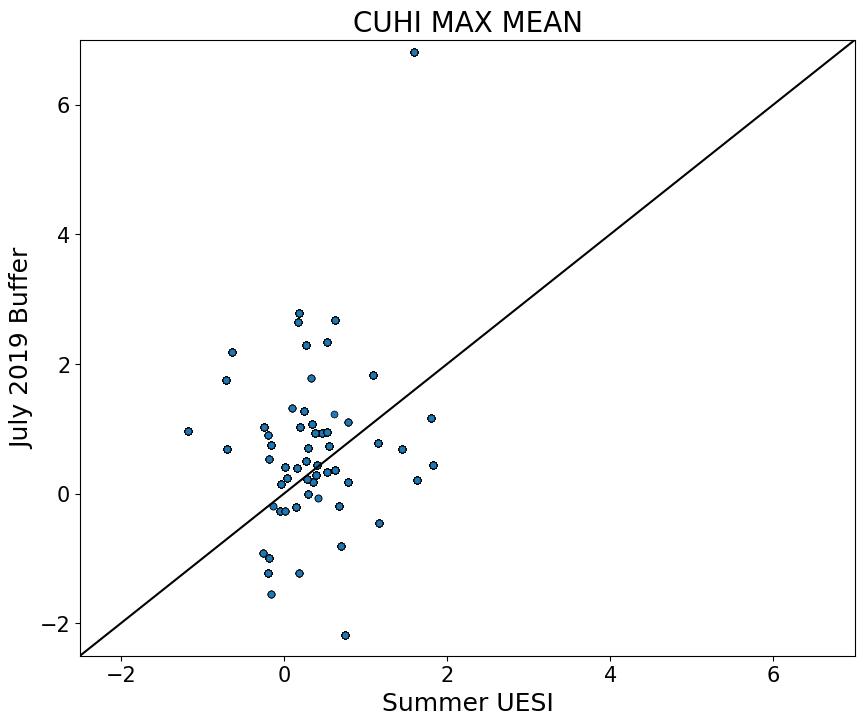

In [88]:
fig , axes = plt.subplots(1,1, figsize = (10,8))

axes.scatter( temp.Summer_CUHIMAX,  temp.CUHI_Tmax, s = 25, edgecolors='k', linewidths=0.5)
axes.set(title = 'CUHI MAX MEAN', 
            xlabel = 'Summer UESI', ylabel = 'July 2019 Buffer')

axesmin = -2.5
axesmax = 7

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])
# x = y line
axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')

In [384]:
# Plotting maps for the city with the most netatmo stations - Berlin, UESI_ID is DEU_R62422

## get the berlin nbhd means 
# for Tmax
berlin_Tmax_netatmo_means = Tmax_gdf[Tmax_gdf.uesi_id == 'DEU_R62422'][['nbhd_code','Temperatur']].groupby('nbhd_code').mean().reset_index()
berlin_gdats = CUHI_cities_july2019_gdf[CUHI_cities_july2019_gdf.uesi_id == 'DEU_R62422']
berlin_Tmax_nbhd_means = berlin_gdats.merge(berlin_Tmax_netatmo_means, on ='nbhd_code', how = 'inner')
# add in the difference variable 
berlin_Tmax_nbhd_means['Netatmo_minus_GDAT'] = berlin_Tmax_nbhd_means.Temperatur - berlin_Tmax_nbhd_means.July_Urban_T_Max_GDAT
# individual netatmo stations for Berlin 
netatmo_berlin_points_tmax = Tmax_gdf[Tmax_gdf.uesi_id == 'DEU_R62422'][['nbhd_code','Temperatur','geometry','landcover_type']]

# for Tmin
berlin_Tmin_netatmo_means = Tmin_gdf[Tmin_gdf.uesi_id == 'DEU_R62422'][['nbhd_code','Temperatur']].groupby('nbhd_code').mean().reset_index()
berlin_gdats = CUHI_cities_july2019_gdf[CUHI_cities_july2019_gdf.uesi_id == 'DEU_R62422']
berlin_Tmin_nbhd_means = berlin_gdats.merge(berlin_Tmin_netatmo_means, on ='nbhd_code', how = 'inner')
# add in the difference variable 
berlin_Tmin_nbhd_means['Netatmo_minus_GDAT'] = berlin_Tmin_nbhd_means.Temperatur - berlin_Tmin_nbhd_means.July_Urban_T_Min_GDAT
# individual netatmo stations for Berlin 
netatmo_berlin_points_tmin = Tmin_gdf[Tmin_gdf.uesi_id == 'DEU_R62422'][['nbhd_code','Temperatur','geometry','landcover_type']]


In [418]:
netatmo_berlin_points_tmax

nbhd_code  Temperatur                   geometry
1456   DEU_R62422_012   37.312903  POINT (13.52670 52.43394)
3955   DEU_R62422_012   29.948387  POINT (13.66033 52.41134)
5194   DEU_R62422_012   32.816129  POINT (13.58401 52.39468)
6812   DEU_R62422_012   27.883871  POINT (13.58931 52.42585)
12651  DEU_R62422_012   28.238710  POINT (13.51135 52.43529)
...               ...         ...                        ...
42333  DEU_R62422_002   26.258065  POINT (13.45368 52.51981)
47568  DEU_R62422_002   25.445161  POINT (13.46628 52.51341)
54122  DEU_R62422_002   24.822581  POINT (13.45696 52.50877)
66073  DEU_R62422_002   26.593548  POINT (13.39030 52.48586)
72732  DEU_R62422_002   24.032258  POINT (13.43560 52.50090)

[492 rows x 3 columns]

In [419]:
netatmo_berlin_points_tmin

nbhd_code  Temperatur                   geometry
622    DEU_R62422_009   17.206452  POINT (13.12406 52.44451)
2268   DEU_R62422_009   17.732258  POINT (13.25617 52.53755)
3098   DEU_R62422_009   17.719355  POINT (13.19637 52.52298)
9463   DEU_R62422_009   17.451613  POINT (13.15424 52.53506)
12593  DEU_R62422_009   17.160000  POINT (13.19673 52.54752)
...               ...         ...                        ...
75935  DEU_R62422_004   14.941935  POINT (13.59681 52.50684)
76061  DEU_R62422_004   15.135484  POINT (13.56209 52.56473)
76159  DEU_R62422_004   14.312903  POINT (13.60935 52.47191)
83265  DEU_R62422_004   13.687097  POINT (13.57089 52.49017)
86537  DEU_R62422_004   14.558065  POINT (13.57490 52.53397)

[547 rows x 3 columns]

(13.054704615371339, 13.794782477221558, 52.32138257814877, 52.69232893497553)

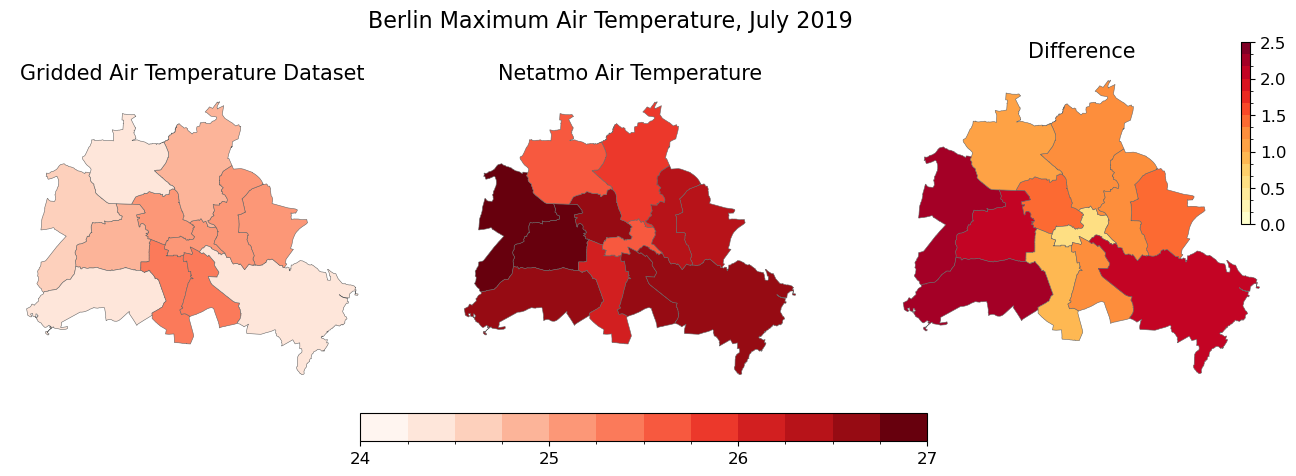

In [377]:
# Plotting maps for the city with the most netatmo stations - Berlin, UESI_ID is DEU_R62422
fig, axes = plt.subplots(1,3, figsize=(16, 8))
#plt.xticks(rotation=90)
fig.suptitle('Berlin Maximum Air Temperature, July 2019', fontsize=16, y = 0.65)

# create the colormap
scale_min = 24
scale_max = 27
cmap = plt.cm.Reds.copy()  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
colormap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(scale_min, scale_max, 13)
norm = mpl.colors.BoundaryNorm(bounds, colormap.N)
bounds_for_colorbar = np.linspace(scale_min, scale_max, 4)


# create the colormap for the differences 
diff_scale_min = 0
diff_scale_max = 2.5
cmap = plt.cm.YlOrRd.copy()  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
diff_colormap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

diff_bounds = np.linspace(diff_scale_min, diff_scale_max, 16)
diff_norm = mpl.colors.BoundaryNorm(diff_bounds, diff_colormap.N)
diff_bounds_for_colorbar = np.linspace(diff_scale_min, diff_scale_max, 6)


im1 = berlin_Tmax_nbhd_means.plot(column='July_Urban_T_Max_GDAT', cmap=colormap, norm = norm, linewidth=0.4, edgecolor=".4", ax = axes[0])
axes[0].set(title = 'Gridded Air Temperature Dataset')

im2 = berlin_Tmax_nbhd_means.plot(column='Temperatur', cmap=colormap, linewidth=0.4, norm = norm, edgecolor=".4", ax = axes[1])
axes[1].set(title = 'Netatmo Air Temperature')

im3 = berlin_Tmax_nbhd_means.plot(column='Netatmo_minus_GDAT', cmap=diff_colormap, linewidth=0.4, norm = diff_norm, edgecolor=".4", ax = axes[2])
axes[2].set(title = 'Difference')
fig.colorbar(plt.cm.ScalarMappable(norm=diff_norm, cmap=diff_colormap), ax=axes[2], 
                 fraction=0.025, pad=-0.1, ticks =diff_bounds_for_colorbar)

fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=axes, orientation='horizontal',fraction=0.046, pad=0.04, ticks =bounds_for_colorbar)

# get rid of the coordinates
axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")


(13.054704615371339, 13.794782477221558, 52.32138257814877, 52.69232893497553)

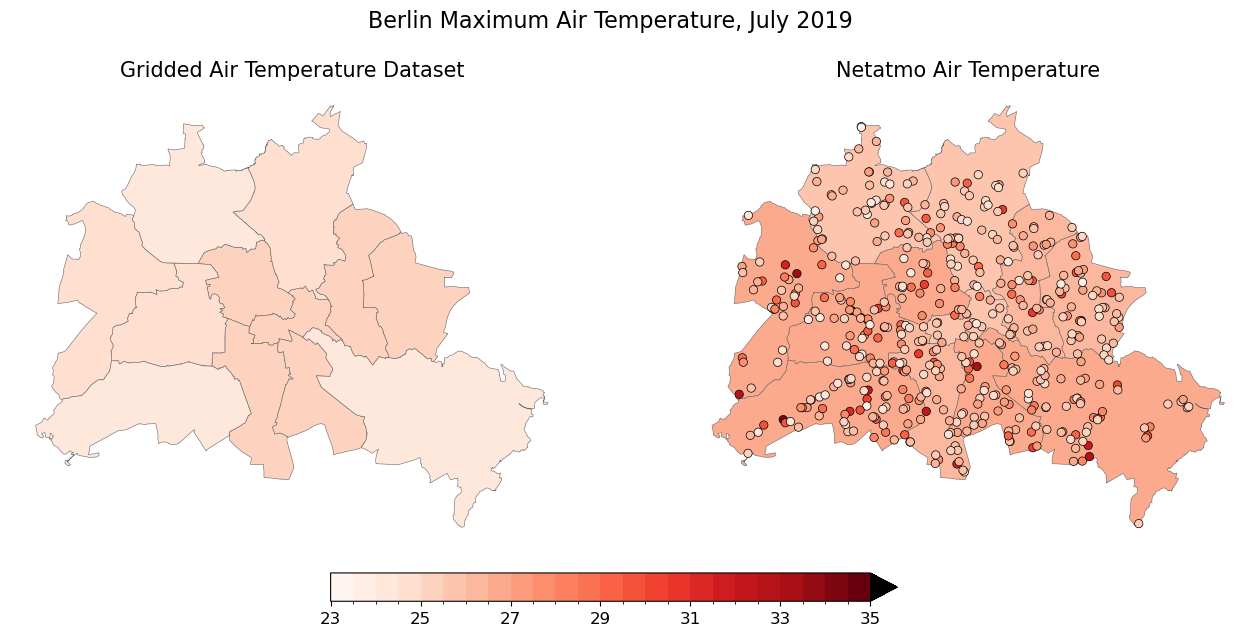

In [417]:
# Plotting maps for the city with the most netatmo stations - Berlin, UESI_ID is DEU_R62422
fig, axes = plt.subplots(1,2, figsize=(16, 8))

fig.suptitle('Berlin Maximum Air Temperature, July 2019', fontsize=16, y = 0.85)
# create the colormap
scale_min = 23
scale_max = 35
cmap = plt.cm.Reds  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
colormap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(scale_min, scale_max, 25)
norm = mpl.colors.BoundaryNorm(bounds, colormap.N)
bounds_for_colorbar = np.linspace(scale_min, scale_max, 7)

colormap.set_over('black')

im1 = berlin_Tmax_nbhd_means.plot(column="July_Urban_T_Max_GDAT", cmap=colormap, norm= norm, linewidth=0.4, edgecolor=".4", ax = axes[0])
axes[0].set(title = 'Gridded Air Temperature Dataset')

im2 = berlin_Tmax_nbhd_means.plot(column="Temperatur", cmap=colormap, linewidth=0.4, norm = norm, edgecolor=".4", ax = axes[1])
axes[1].set(title = 'Netatmo Air Temperature')
netatmo_berlin_points_tmax.plot(ax = axes[1], marker = 'o', linewidths = 0.5,edgecolor = 'black', column = 'Temperatur',
                          cmap = colormap, vmax = 35)

#axes[1].scatter(netatmo_berlin_points, 


#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=axes, orientation='horizontal',fraction=0.046, pad=0.04, ticks =bounds_for_colorbar, 
             extend = 'max' )

# get rid of the coordinates
axes[0].axis("off")
axes[1].axis("off")


(13.054704615371339, 13.794782477221558, 52.32138257814877, 52.69232893497553)

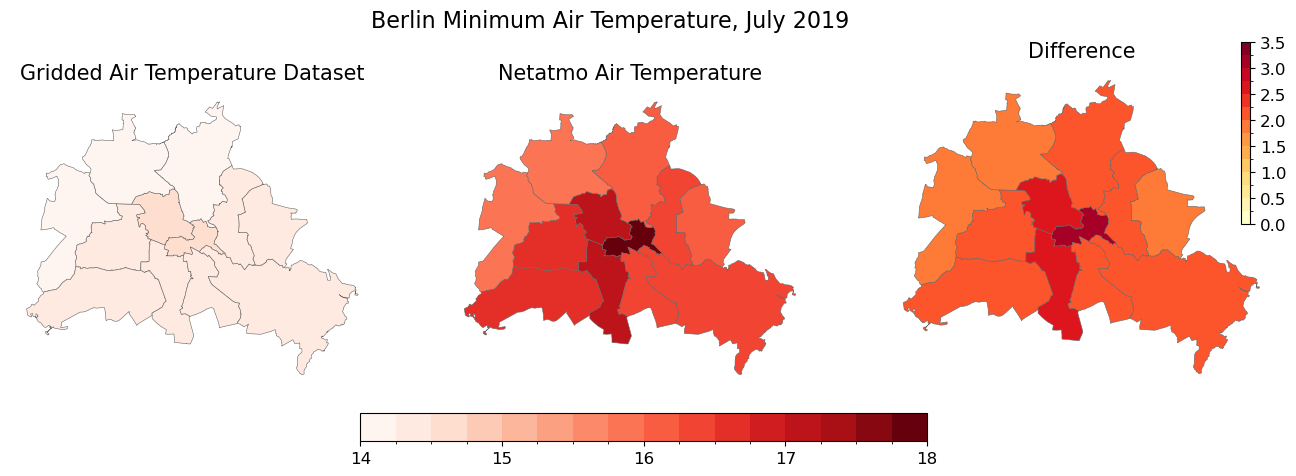

In [416]:
# Plotting maps for the city with the most netatmo stations - Berlin, UESI_ID is DEU_R62422

###### MINIMUM TEMPERATURE #######

fig, axes = plt.subplots(1,3, figsize=(16, 8))
fig.suptitle('Berlin Minimum Air Temperature, July 2019', fontsize=16, y = 0.65)

# create the colormap
scale_min = 14
scale_max = 18
cmap = plt.cm.Reds.copy()  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
colormap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(scale_min, scale_max, 17)
norm = mpl.colors.BoundaryNorm(bounds, colormap.N)
bounds_for_colorbar = np.linspace(scale_min, scale_max, 5)


# create the colormap for the differences 
diff_scale_min = 0
diff_scale_max = 3.5
cmap = plt.cm.YlOrRd.copy()  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
diff_colormap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

diff_bounds = np.linspace(diff_scale_min, diff_scale_max, 15)
diff_norm = mpl.colors.BoundaryNorm(diff_bounds, diff_colormap.N)
diff_bounds_for_colorbar = np.linspace(diff_scale_min, diff_scale_max, 8)


im1 = berlin_Tmin_nbhd_means.plot(column='July_Urban_T_Min_GDAT', cmap=colormap, norm = norm, linewidth=0.4, edgecolor=".4", ax = axes[0])
axes[0].set(title = 'Gridded Air Temperature Dataset')

im2 = berlin_Tmin_nbhd_means.plot(column='Temperatur', cmap=colormap, linewidth=0.4, norm = norm, edgecolor=".4", ax = axes[1])
axes[1].set(title = 'Netatmo Air Temperature')

im3 = berlin_Tmin_nbhd_means.plot(column='Netatmo_minus_GDAT', cmap=diff_colormap, linewidth=0.4, norm = diff_norm, edgecolor=".4", ax = axes[2])
axes[2].set(title = 'Difference')
fig.colorbar(plt.cm.ScalarMappable(norm=diff_norm, cmap=diff_colormap), ax=axes[2], 
                 fraction=0.025, pad=-0.1, ticks =diff_bounds_for_colorbar)

fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=axes, orientation='horizontal',fraction=0.046, pad=0.04, ticks =bounds_for_colorbar)

# get rid of the coordinates
axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")


(13.054704615371339, 13.794782477221558, 52.32138257814877, 52.69232893497553)

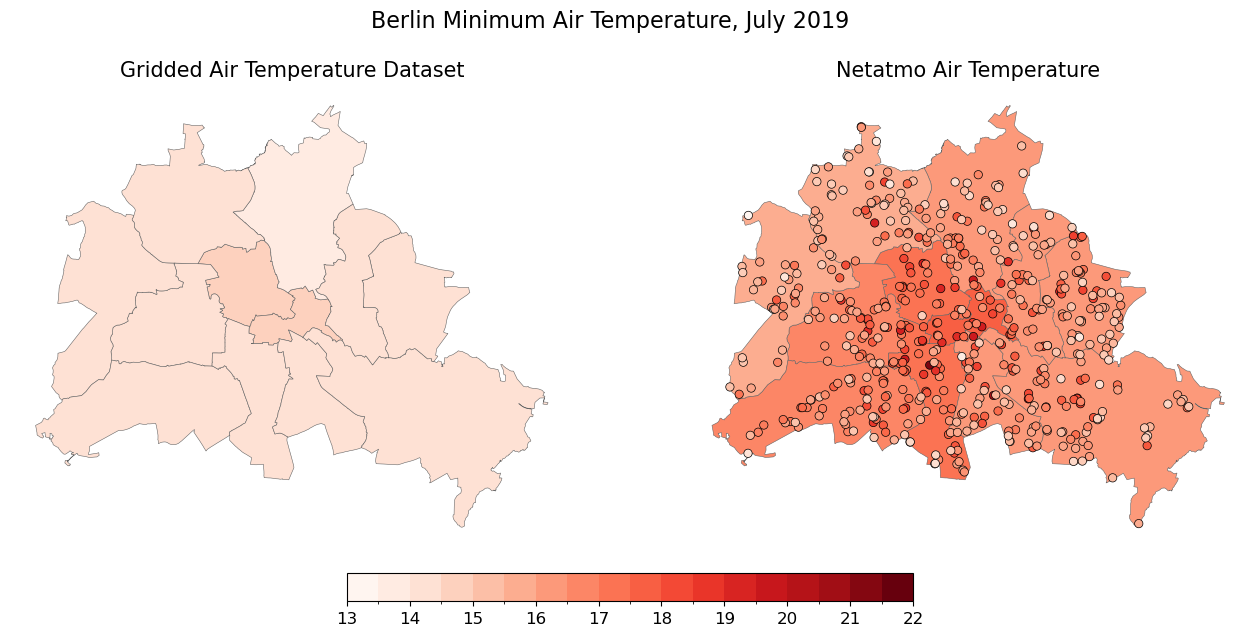

In [399]:
# Plotting maps for the city with the most netatmo stations - Berlin, UESI_ID is DEU_R62422
fig, axes = plt.subplots(1,2, figsize=(16, 8))

fig.suptitle('Berlin Minimum Air Temperature, July 2019', fontsize=16, y = 0.85)
# create the colormap
scale_min = 13
scale_max = 22
cmap = plt.cm.Reds  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
colormap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(scale_min, scale_max, 19)
norm = mpl.colors.BoundaryNorm(bounds, colormap.N)
bounds_for_colorbar = np.linspace(scale_min, scale_max, 10)

colormap.set_over('black')

im1 = berlin_Tmin_nbhd_means.plot(column="July_Urban_T_Min_GDAT", cmap=colormap, norm= norm, linewidth=0.4, edgecolor=".4", ax = axes[0])
axes[0].set(title = 'Gridded Air Temperature Dataset')

im2 = berlin_Tmin_nbhd_means.plot(column="Temperatur", cmap=colormap, linewidth=0.4, norm = norm, edgecolor=".4", ax = axes[1])
axes[1].set(title = 'Netatmo Air Temperature')
netatmo_berlin_points_tmin.plot(ax = axes[1], marker = 'o', linewidths = 0.5,edgecolor = 'black', column = 'Temperatur',
                          cmap = colormap, vmax = 22)

#axes[1].scatter(netatmo_berlin_points, 


#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=axes, orientation='horizontal',fraction=0.046, pad=0.04, ticks =bounds_for_colorbar)

# get rid of the coordinates
axes[0].axis("off")
axes[1].axis("off")


In [392]:
print('GDAT Tmax range:', berlin_Tmax_nbhd_means.July_Urban_T_Max_GDAT.min(),berlin_Tmax_nbhd_means.July_Urban_T_Max_GDAT.max())
print('Netatmo Tmax range:', berlin_Tmax_nbhd_means.Temperatur.min(),berlin_Tmax_nbhd_means.Temperatur.max())
print('Netatmo_minus_GDAT Tmax range:', berlin_Tmax_nbhd_means.Netatmo_minus_GDAT.min(),berlin_Tmax_nbhd_means.Netatmo_minus_GDAT.max())
print('Station Tmax range:', netatmo_berlin_points_tmax.Temperatur.min(),netatmo_berlin_points_tmax.Temperatur.max())
print('-------------------------------------------------------------------------------------------------------------')
print('GDAT Tmin range:', berlin_Tmin_nbhd_means.July_Urban_T_Min_GDAT.min(),berlin_Tmin_nbhd_means.July_Urban_T_Min_GDAT.max())
print('Netatmo Tmin range:', berlin_Tmin_nbhd_means.Temperatur.min(),berlin_Tmin_nbhd_means.Temperatur.max())
print('Netatmo_minus_GDAT Tmin range:', berlin_Tmin_nbhd_means.Netatmo_minus_GDAT.min(),berlin_Tmin_nbhd_means.Netatmo_minus_GDAT.max())
print('Station Tmin range:', netatmo_berlin_points_tmin.Temperatur.min(),netatmo_berlin_points_tmin.Temperatur.max())


GDAT Tmax range: 24.4574968216789 25.32554329117001
Netatmo Tmax range: 25.564064160795947 26.95876329825162
Netatmo_minus_GDAT Tmax range: 0.5194379772258273 2.321092721542147
Station Tmax range: 22.69032258064516 40.18064516129032
-------------------------------------------------------------------------------------------------------------
GDAT Tmin range: 13.93350269505859 14.612316505011968
Netatmo Tmin range: 15.891712286138036 17.754196305486627
Netatmo_minus_GDAT Tmin range: 1.7608278146816403 3.1418798004746584
Station Tmin range: 13.051612903225807 21.58709677419355


In [401]:
Tmin_gdf[Tmin_gdf.uesi_id == 'DEU_R62422']

system:index_left    Humidity                 ID        Lat  \
622    000000000000000041dd   52.290323  70:ee:50:04:fe:be  52.444507   
2268   000000000000000040d7   60.709677  70:ee:50:04:f4:28  52.537552   
3098   00000000000000007acc   62.096774  70:ee:50:17:91:50  52.522983   
9463   00000000000000007784   67.387097  70:ee:50:17:6e:1c  52.535055   
12593  00000000000000012e64   68.833333  70:ee:50:36:bb:4c  52.547518   
...                     ...         ...                ...        ...   
75935  00000000000000013395   85.354839  70:ee:50:36:e3:b6  52.506836   
76061  000000000000000063b0   85.419355  70:ee:50:13:54:d4  52.564728   
76159  00000000000000006af8   85.451613  70:ee:50:14:61:c0  52.471909   
83265  0000000000000001334f   89.225806  70:ee:50:36:e1:7c  52.490167   
86537  00000000000000001a14  100.000000  70:ee:50:01:e1:7e  52.533972   

             Lon  Temperatur landcover_type  \
622    13.124059   17.206452             10   
2268   13.256168   17.732258             50   
3098   13.196372   17.719355             10   
9463   13.154244   17.451613             10   
12593  13.196727   17.160000             50   
...          ...         ...            ...   
75935  13.596807   14.941935             50   
76061  13.562088   15.135484             50   
76159  13.609354   14.312903             10   
83265  13.570889   13.687097             50   
86537  13.574896   14.558065             10   

                                               .geo_left  \
622    {"type":"Point","coordinates":[13.124057434209...   
2268   {"type":"Point","coordinates":[13.256167221119...   
3098   {"type":"Point","coordinates":[13.196370675993...   
9463   {"type":"Point","coordinates":[13.154245548341...   
12593  {"type":"Point","coordinates":[13.196727404077...   
...                                                  ...   
75935  {"type":"Point","coordinates":[13.596806868794...   
76061  {"type":"Point","coordinates":[13.562088307992...   
76159  {"type":"Point","coordinates":[13.609354779158...   
83265  {"type":"Point","coordinates":[13.570890573471...   
86537  {"type":"Point","coordinates":[13.574894846217...   

                        geometry Landcover_Desc  ...  July_Urban_CUHI_Count  \
622    POINT (13.12406 52.44451)     Tree cover  ...                    139   
2268   POINT (13.25617 52.53755)       Built-up  ...                    139   
3098   POINT (13.19637 52.52298)     Tree cover  ...                    139   
9463   POINT (13.15424 52.53506)     Tree cover  ...                    139   
12593  POINT (13.19673 52.54752)       Built-up  ...                    139   
...                          ...            ...  ...                    ...   
75935  POINT (13.59681 52.50684)       Built-up  ...                    103   
76061  POINT (13.56209 52.56473)       Built-up  ...                    103   
76159  POINT (13.60935 52.47191)     Tree cover  ...                    103   
83265  POINT (13.57089 52.49017)       Built-up  ...                    103   
86537  POINT (13.57490 52.53397)     Tree cover  ...                    103   

      July_Urban_Count  July_Urban_T_Max_GDAT  July_Urban_T_Min_GDAT  \
622                312              24.637671              14.017127   
2268               312              24.637671              14.017127   
3098               312              24.637671              14.017127   
9463               312              24.637671              14.017127   
12593              312              24.637671              14.017127   
...                ...                    ...                    ...   
75935              322              25.016671              14.303031   
76061              322              25.016671              14.303031   
76159              322              25.016671              14.303031   
83265              322              25.016671              14.303031   
86537              322              25.016671              14.303031   

            layer       nbhd_code

In [408]:
## get the berlin nbhd means 
# for Tmax
urb_berlin_Tmax_netatmo_means = Tmax_gdf[(Tmax_gdf.uesi_id == 'DEU_R62422')&(Tmax_gdf.landcover_type == '50')][['nbhd_code','Temperatur']].groupby(
                                                                                                                'nbhd_code').mean().reset_index()
urb_berlin_Tmax_nbhd_means = berlin_gdats.merge(urb_berlin_Tmax_netatmo_means, on ='nbhd_code', how = 'inner')
# add in the difference variable 
urb_berlin_Tmax_nbhd_means['Netatmo_minus_GDAT'] = urb_berlin_Tmax_nbhd_means.Temperatur - urb_berlin_Tmax_nbhd_means.July_Urban_T_Max_GDAT
# individual netatmo stations for Berlin 
urb_netatmo_berlin_points_tmax = Tmax_gdf[(Tmax_gdf.uesi_id == 'DEU_R62422')&(Tmax_gdf.landcover_type == '50')][['nbhd_code','Temperatur','geometry']]

##rural landcover types
rur_berlin_Tmax_netatmo_means = Tmax_gdf[(Tmax_gdf.uesi_id == 'DEU_R62422')&(Tmax_gdf.landcover_type != '50')][['nbhd_code','Temperatur']].groupby(
                                                                                                                'nbhd_code').mean().reset_index()
rur_berlin_Tmax_nbhd_means = berlin_gdats.merge(rur_berlin_Tmax_netatmo_means, on ='nbhd_code', how = 'inner')
# add in the difference variable 
rur_berlin_Tmax_nbhd_means['Netatmo_minus_GDAT'] = rur_berlin_Tmax_nbhd_means.Temperatur - rur_berlin_Tmax_nbhd_means.July_Urban_T_Max_GDAT
# individual netatmo stations for Berlin 
rur_netatmo_berlin_points_tmax = Tmax_gdf[(Tmax_gdf.uesi_id == 'DEU_R62422')&(Tmax_gdf.landcover_type != '50')][['nbhd_code','Temperatur','geometry']]


# for Tmin
urb_berlin_Tmin_netatmo_means = Tmin_gdf[(Tmin_gdf.uesi_id == 'DEU_R62422')&(Tmin_gdf.landcover_type == '50')][['nbhd_code','Temperatur']].groupby(
                                                                                                        'nbhd_code').mean().reset_index()
urb_berlin_Tmin_nbhd_means = berlin_gdats.merge(urb_berlin_Tmin_netatmo_means, on ='nbhd_code', how = 'inner')
# add in the difference variable 
urb_berlin_Tmin_nbhd_means['Netatmo_minus_GDAT'] = urb_berlin_Tmin_nbhd_means.Temperatur - urb_berlin_Tmin_nbhd_means.July_Urban_T_Min_GDAT
# individual netatmo stations for Berlin 
urb_netatmo_berlin_points_tmin = Tmin_gdf[(Tmin_gdf.uesi_id == 'DEU_R62422')&(Tmin_gdf.landcover_type == '50')][['nbhd_code','Temperatur','geometry']]

##rural landcover types
rur_berlin_Tmin_netatmo_means = Tmin_gdf[(Tmin_gdf.uesi_id == 'DEU_R62422')&(Tmin_gdf.landcover_type != '50')][['nbhd_code','Temperatur']].groupby(
                                                                                                                'nbhd_code').mean().reset_index()
rur_berlin_Tmin_nbhd_means = berlin_gdats.merge(rur_berlin_Tmin_netatmo_means, on ='nbhd_code', how = 'inner')
# add in the difference variable 
rur_berlin_Tmin_nbhd_means['Netatmo_minus_GDAT'] = rur_berlin_Tmin_nbhd_means.Temperatur - rur_berlin_Tmin_nbhd_means.July_Urban_T_Min_GDAT
# individual netatmo stations for Berlin 
rur_netatmo_berlin_points_tmax = Tmin_gdf[(Tmin_gdf.uesi_id == 'DEU_R62422')&(Tmin_gdf.landcover_type != '50')][['nbhd_code','Temperatur','geometry']]


In [409]:
urb_berlin_Tmax_netatmo_means 


nbhd_code  Temperatur
0   DEU_R62422_001   28.049589
1   DEU_R62422_002   25.696799
2   DEU_R62422_003   26.209591
3   DEU_R62422_004   27.071261
4   DEU_R62422_005   26.982922
5   DEU_R62422_006   26.936452
6   DEU_R62422_007   26.056425
7   DEU_R62422_008   25.888775
8   DEU_R62422_009   27.478907
9   DEU_R62422_010   26.655586
10  DEU_R62422_011   26.005772
11  DEU_R62422_012   26.783619

(13.054704615371339, 13.794782477221558, 52.32138257814877, 52.69232893497553)

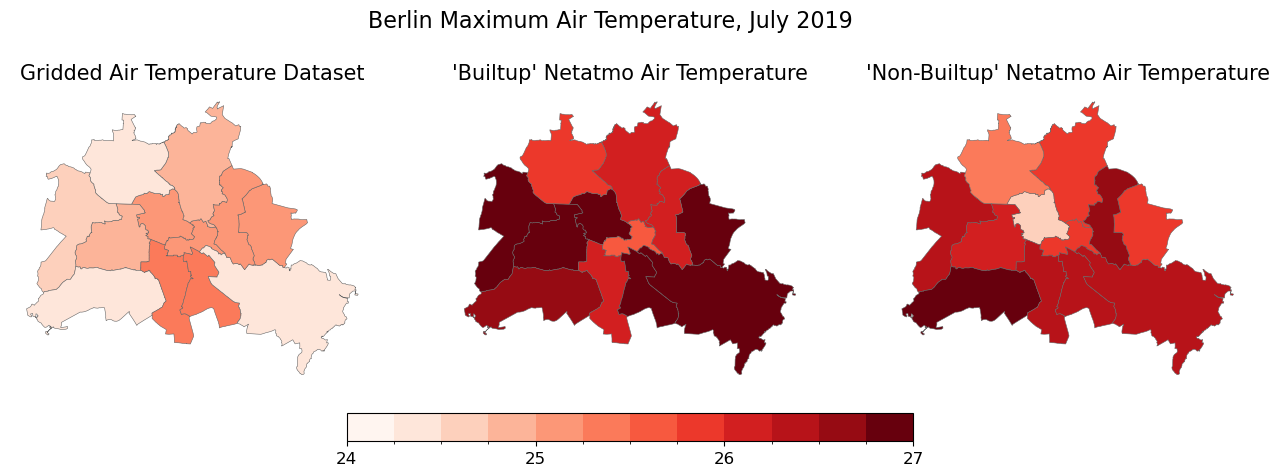

In [413]:
#### Looking at using only the urban landcover types vs only non urban landcover types

fig, axes = plt.subplots(1,3, figsize=(16, 8))
#plt.xticks(rotation=90)
fig.suptitle('Berlin Maximum Air Temperature, July 2019', fontsize=16, y = 0.65)

# create the colormap
scale_min = 24
scale_max = 27
cmap = plt.cm.Reds.copy()  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
colormap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(scale_min, scale_max, 13)
norm = mpl.colors.BoundaryNorm(bounds, colormap.N)
bounds_for_colorbar = np.linspace(scale_min, scale_max, 4)


# create the colormap for the differences 
diff_scale_min = 0
diff_scale_max = 2.5
cmap = plt.cm.YlOrRd.copy()  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
diff_colormap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

diff_bounds = np.linspace(diff_scale_min, diff_scale_max, 16)
diff_norm = mpl.colors.BoundaryNorm(diff_bounds, diff_colormap.N)
diff_bounds_for_colorbar = np.linspace(diff_scale_min, diff_scale_max, 6)


im1 = urb_berlin_Tmax_nbhd_means.plot(column='July_Urban_T_Max_GDAT', cmap=colormap, norm = norm, linewidth=0.4, edgecolor=".4", ax = axes[0])
axes[0].set(title = 'Gridded Air Temperature Dataset')

im2 = urb_berlin_Tmax_nbhd_means.plot(column='Temperatur', cmap=colormap, linewidth=0.4, norm = norm, edgecolor=".4", ax = axes[1])
axes[1].set(title = "'Builtup' Netatmo Air Temperature")

im2 = rur_berlin_Tmax_nbhd_means.plot(column='Temperatur', cmap=colormap, linewidth=0.4, norm = norm, edgecolor=".4", ax = axes[2])
axes[2].set(title = "'Non-Builtup' Netatmo Air Temperature")


#im3 = urb_berlin_Tmax_nbhd_means.plot(column='Netatmo_minus_GDAT', cmap=diff_colormap, linewidth=0.4, norm = diff_norm, edgecolor=".4", ax = axes[2])
#axes[2].set(title = 'Difference')
#fig.colorbar(plt.cm.ScalarMappable(norm=diff_norm, cmap=diff_colormap), ax=axes[2], 
#                 fraction=0.025, pad=-0.1, ticks =diff_bounds_for_colorbar)

fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=axes, orientation='horizontal',fraction=0.046, pad=0.04, ticks =bounds_for_colorbar)

# get rid of the coordinates
axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

(13.054704615371339, 13.794782477221558, 52.32138257814877, 52.69232893497553)

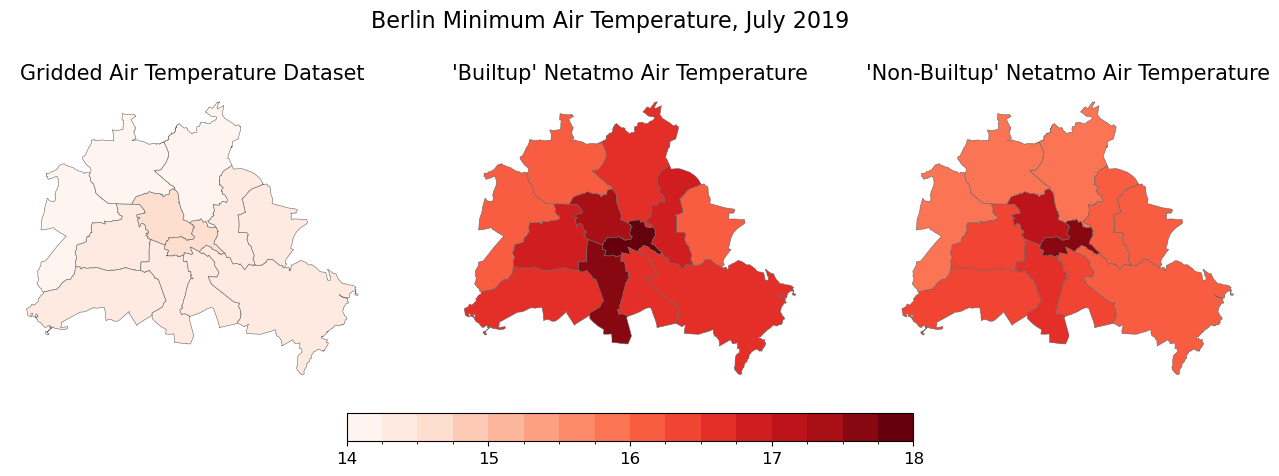

In [415]:
fig, axes = plt.subplots(1,3, figsize=(16, 8))
#plt.xticks(rotation=90)
fig.suptitle('Berlin Minimum Air Temperature, July 2019', fontsize=16, y = 0.65)

# create the colormap
scale_min = 14
scale_max = 18
cmap = plt.cm.Reds.copy()  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
colormap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(scale_min, scale_max, 17)
norm = mpl.colors.BoundaryNorm(bounds, colormap.N)
bounds_for_colorbar = np.linspace(scale_min, scale_max, 5)

# create the colormap for the differences 
diff_scale_min = 0
diff_scale_max = 2.5
cmap = plt.cm.YlOrRd.copy()  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
diff_colormap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

diff_bounds = np.linspace(diff_scale_min, diff_scale_max, 16)
diff_norm = mpl.colors.BoundaryNorm(diff_bounds, diff_colormap.N)
diff_bounds_for_colorbar = np.linspace(diff_scale_min, diff_scale_max, 6)


im1 = urb_berlin_Tmin_nbhd_means.plot(column='July_Urban_T_Min_GDAT', cmap=colormap, norm = norm, linewidth=0.4, edgecolor=".4", ax = axes[0])
axes[0].set(title = 'Gridded Air Temperature Dataset')

im2 = urb_berlin_Tmin_nbhd_means.plot(column='Temperatur', cmap=colormap, linewidth=0.4, norm = norm, edgecolor=".4", ax = axes[1])
axes[1].set(title = "'Builtup' Netatmo Air Temperature")

im2 = rur_berlin_Tmin_nbhd_means.plot(column='Temperatur', cmap=colormap, linewidth=0.4, norm = norm, edgecolor=".4", ax = axes[2])
axes[2].set(title = "'Non-Builtup' Netatmo Air Temperature")


#im3 = urb_berlin_Tmax_nbhd_means.plot(column='Netatmo_minus_GDAT', cmap=diff_colormap, linewidth=0.4, norm = diff_norm, edgecolor=".4", ax = axes[2])
#axes[2].set(title = 'Difference')
#fig.colorbar(plt.cm.ScalarMappable(norm=diff_norm, cmap=diff_colormap), ax=axes[2], 
#                 fraction=0.025, pad=-0.1, ticks =diff_bounds_for_colorbar)

fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=axes, orientation='horizontal',fraction=0.046, pad=0.04, ticks =bounds_for_colorbar)

# get rid of the coordinates
axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")